<h1><center><b> C3 AI Data Challenge</b></center></h1>
 <h2><center>Learning to account for population heterogeneity from partial and imperfect measurements </center></h2>

<br>
<br>



 _Claire Donnat, University of Chicago_

 _Freddy Bunbury, Carnegie Institution for Science (Stanford)_

_Nina Miolane, University of California Santa Barbara (UCSB)_

<br>
<br>
<br>

<p>In the era of COVID-19, going back to work, to school, travelling, attending live events, all previously normal activities, now rely on accurately determining the risk of an outbreak. In this context, rapid antigen testing seems to offer an affordable and scalable solution, but its inherent sensitivity limitations means that all too often infectious individuals are not detected. Yet, the data now shows that individuals not only have vastly different risks of dying from COVID, but also of spreading the disease. Considering the exponential and chaotic nature of COVID-19 spread, neglecting this heterogeneity makes accurate modelling of COVID-19 near impossible. So how can we account for this heterogeneity, how can we identify relevant markers that differentiate amongst high and low-risk individuals? </p>
<br>

Our solution is a machine-learning model to integrate rapid test results alongside symptoms, exposure-risk, lifestyle factors and location into a more accurate diagnosis with an associated confidence interval. This is a difficult task: the training must be unsupervised since the test results are unreliable, but most importantly, despite the glut of available datasets and clinical studies, every one of these sources is either incomplete or subject to some sort of sampling bias--- thus hindering the generalizability of the approach. So how do we extract information from each of these data sources and combine them to estimate individual probabilities of infectiousness?
<br>

To leverage power across multiple data sources we use a Bayesian generative model. Our tailored, Stochastic Expectation-Maximization algorithm, which was recently accepted for publication at Neurips, solves for the model parameters in a fast and efficient way. To train the network, we pool information from 4 of C3AI’s datasets, the Facebook Survey data, as well as many published study results and Bayesian meta-analyses. The output is a statistically sound estimate of the probability that an individual has COVID, while also quantifying the degree of certainty.
<br>


This notebook details all the data fusion, integration and processing that was achieved to train the algorithm.
The dashboard and helper functions that we use are provided in the folder that goes along with this notebook.





In [133]:
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sys, os
import scipy as sc
import seaborn as sb
import time

from google.colab import drive
drive.mount('/content/drive')

import csv
import datetime
from functools import partial
import re


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
os.chdir("/content/drive/My Drive/C3AI_code")
import c3aidatalake
from helper import *

# I. Load the Carbon Health data 

The main dataset that we use for this project's  purposes is the Carbon Health data. Our goal is to train the Bayesian network on the participant data provided by carbon Health, while using other complementary data sources as a way of enriching the learning procedure and correct for potential biases in the sampling frame.
Here, for convenience purposes, we load the Carbon Health data directly from the associated github repo (link provided on the C3AI data lake website).

In [135]:
#### Start by 
basepath = '/content/drive/My Drive/C3AI_code/covidclinicaldata/data/'
it = 0
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        if it == 0:
          data = pd.read_csv(os.path.join(basepath, entry))
          #print(data.columns)
        else:
          df  = pd.read_csv(os.path.join(basepath, entry))
          #print(df.columns)
          data = pd.concat([data, df])
        it += 1

print("data shape: ", data.shape)

data shape:  (11169, 46)


This is thus a very large dataset, with over 11,169 entries. We begin by a brief data analysis, as well as some light data preprocessing to highlight the potential for this dataset and make it amenable to training, before feeding it as training set into the algorithm.

In [136]:
data.head()

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,2020-04-07,SARS COV 2 RNA RTPCR,Nasopharyngeal,Negative,58,True,NaN,False,False,False,False,False,False,False,False,36.95,81.0,126.0,82.0,18.0,97.0,NaN,NaN,False,False,False,False,28.0,True,Severe,NaN,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,2020-04-07,"SARS-CoV-2, NAA",Oropharyngeal,Negative,35,False,NaN,False,False,False,False,False,False,False,False,36.75,77.0,131.0,86.0,16.0,98.0,NaN,NaN,False,False,False,False,NaN,True,Mild,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2020-04-07,SARS CoV w/CoV 2 RNA,Oropharyngeal,Negative,12,NaN,NaN,False,False,False,False,False,False,False,False,36.95,74.0,122.0,73.0,17.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2020-04-07,SARS COV 2 RNA RTPCR,Nasopharyngeal,Negative,46,True,True,False,False,False,False,False,False,False,False,36.75,66.0,128.0,76.0,18.0,100.0,NaN,NaN,False,False,NaN,NaN,3.0,True,Moderate,False,True,Moderate,False,True,False,False,False,False,False,True,NaN,NaN,NaN,NaN,False
4,2020-04-07,SARS CoV w/CoV 2 RNA,Nasopharyngeal,Negative,-1,False,NaN,False,False,False,False,False,False,False,False,36.25,NaN,NaN,NaN,12.0,NaN,NaN,NaN,False,False,False,False,4.0,True,NaN,True,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False


### A. Investigate the dataset


Let us start by looking at a few of the characteristics of this dataset. This is important for identifying potential biases, and ways in which the data needs to be cleaned and pre-processed.

In particular, we need to check for the following:
- class imbalance
- presence of nans
- binarization of symptoms where applicable
- simplification of certain categorical features.

In [137]:
dict_corr ={'type_test':'test_name',
            'results': 'covid19_test_results',
            'date_test_taken': 'batch_date',
            'howShortOfBreath': 'sob_severity'
            }
data.rename(columns={v:k  for k, v in dict_corr.items()}, inplace=True)
data.columns

Index(['date_test_taken', 'type_test', 'swab_type', 'results', 'age',
       'high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes',
       'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker',
       'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', 'rapid_flu_results',
       'rapid_strep_results', 'ctab', 'labored_respiration', 'rhonchi',
       'wheezes', 'days_since_symptom_onset', 'cough', 'cough_severity',
       'fever', 'sob', 'howShortOfBreath', 'diarrhea', 'fatigue', 'headache',
       'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore',
       'sore_throat', 'cxr_findings', 'cxr_impression', 'cxr_label',
       'cxr_link', 'er_referral'],
      dtype='object')

In [138]:
print(" %i different types of tests" % (len(np.unique(data.type_test))))
print(" %i different types of results: %s and %s" % (len(np.unique(data.results) ),
                                                    np.unique(data.results)[0],
                                                    np.unique(data.results)[1]))
print(" %1.3f percent of positive tests, or a total of %i patients" % (100* np.mean(data.results  == "Positive"),
                                                                       np.sum(data.results  == "Positive")))
print(" Different types of cough: ", (np.unique(data.cough_severity[pd.isnull(data.cough_severity) ==False])))

 5 different types of tests
 2 different types of results: Negative and Positive
 2.820 percent of positive tests, or a total of 315 patients
 Different types of cough:  ['Mild' 'Moderate' 'Severe']


In [139]:
#### Let's replace the Nans entries in the dataset by 0
#### We assume that for this specific dataset, which seems to have been 
#### collected by medical profession, missingness is equivalent to absence
#### of the symptoms
SYMPTOMS = ['ctab',
            'rhonchi',
            'wheezes',
            'cough', 
            'fever', 
            'sob', 
            'diarrhea',
            'fatigue', 
            'headache',
            'loss_of_smell', 
            'loss_of_taste', 
            'runny_nose', 
            'muscle_sore',
            'sore_throat']
SYMPTOMS4DASHBOARD = ['cough',
 'fever',
 'sob',
 'diarrhea',
 'fatigue',
 'headache',
 'loss_of_smell',
 'loss_of_taste',
 'runny_nose',
 'muscle_sore',
 'sore_throat']
for s in SYMPTOMS:
  print("%s:  %i missing entries, %i false and %i trues." %(s, np.sum(pd.isnull(data[s])),
                                                            np.sum((data[s] == False)),
                                                            np.sum((data[s] == True))))
  data[s].loc[pd.isnull(data[s])] = False

ctab:  5293 missing entries, 4881 false and 995 trues.
rhonchi:  6658 missing entries, 3631 false and 880 trues.
wheezes:  6344 missing entries, 3795 false and 1030 trues.
cough:  15 missing entries, 9034 false and 2120 trues.
fever:  2532 missing entries, 7894 false and 743 trues.
sob:  206 missing entries, 9756 false and 1207 trues.
diarrhea:  187 missing entries, 10396 false and 586 trues.
fatigue:  176 missing entries, 9318 false and 1675 trues.
headache:  183 missing entries, 9415 false and 1571 trues.
loss_of_smell:  190 missing entries, 10753 false and 226 trues.
loss_of_taste:  190 missing entries, 10744 false and 235 trues.
runny_nose:  187 missing entries, 10016 false and 966 trues.
muscle_sore:  182 missing entries, 9901 false and 1086 trues.
sore_throat:  183 missing entries, 9666 false and 1320 trues.


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [140]:
data['sob']

0       False
1       False
2       False
3        True
4       False
        ...  
1441    False
1442    False
1443    False
1444    False
1445    False
Name: sob, Length: 11169, dtype: object

In [141]:
data['result'] = data['results'].apply(lambda x : 0.0 + 1.0 * (x == "Positive")  )
data['howShortOfBreath'] = data['howShortOfBreath'].apply(lambda x : 0.0 * pd.isnull(x) \
                                                          + 1.0 * (x == "Mild") \
                                                          + 2.0 * (x == "Moderate") \
                                                          + 3.0 * (x == "Severe")  )
data['cough_severity'] = data['cough_severity'].apply(lambda x : 0.0 * pd.isnull(x) \
                                                          + 1.0 * (x == "Mild") \
                                                          + 2.0 * (x == "Moderate") \
                                                          + 3.0 * (x == "Severe")  )

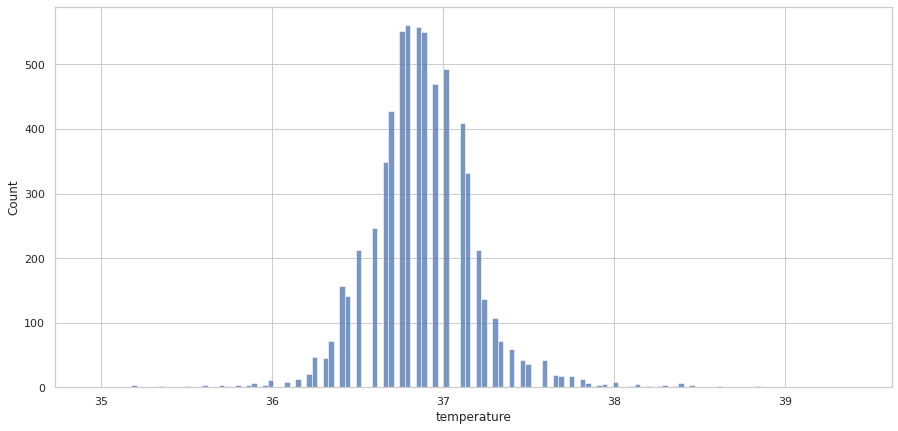

In [142]:
sb.histplot(data["temperature"].loc[pd.isnull(data.temperature) == False])

In [143]:
### Define a fever severity category, since the actual temperature itself might
### nbe a little too noisy or granular (use medical defition)
data['fever_severity'] = data['temperature'].apply(lambda x : 0.0 * pd.isnull(x) \
                                                          + 1.0 * (x >=37.8) \
                                                          + 1.0 * (x >=38) \
                                                          + 1.0 * (x >=39.5) )

In [144]:
### Create the list of all categorical (k>2) symptoms as well
SYMPTOMS_QUANT = ['howShortOfBreath',
                  'fever_severity',
                  'cough_severity']

In [145]:
### Correct some entries (to be consistent across columns)
data.sob.iloc[np.where( (data.sob == False)  * (pd.isnull(data.howShortOfBreath) > 0))[0]] = True
data.cough.iloc[np.where( (data.cough == False)  * (data.cough_severity > 0))[0]] = True
data.temperature.iloc[np.where( (data.temperature == False)  * (data.fever_severity > 0))[0]] = True


### We also found that anterior nares/mares swabs are identical to Nasal
### We also regroup Oropharyngeal and Nasopharyngeal

data.swab_type.iloc[np.where( (data.swab_type == "Oropharyngeal" ))] = 'Nasopharyngeal' 
data.swab_type.iloc[np.where( (data.swab_type == "anterior nares") | (data.swab_type == "anterior mares" ))] = "Nasal"  

### To be honest, we don't have enough data on the relative sensitivities of 
### these different tests. So let's say we keep it for the future.
### Instead, we are going to stratify on tests type : rapid vs pcr
print(np.unique(data['type_test']))
data['test'] = data['type_test'].apply(lambda x : ('Rapid' in x) * 'antibody' + ('Rapid' not in x) * 'pcr' )

['Rapid COVID-19 Test' 'SARS COV 2 RNA RTPCR' 'SARS COV2 NAAT'
 'SARS CoV w/CoV 2 RNA' 'SARS-CoV-2, NAA']


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying t

In [146]:
np.unique(data['test'])

array(['antibody', 'pcr'], dtype=object)

In [147]:
np.unique(data.swab_type)

array(['Nasal', 'Nasopharyngeal'], dtype=object)

In [148]:
### Now let's define a category: symptomatic vs asymptomatic individuals
data["symptomatic"] = (data[SYMPTOMS + SYMPTOMS_QUANT].sum(1)>0)
print("There are %i symptomatic (%1.2f percents) participants" %(np.sum(data["symptomatic"] ),
                                                                 100*np.mean(data["symptomatic"] )
                                                                 ))

There are 5354 symptomatic (47.94 percents) participants


In [149]:
### Another essential parameter in the model is the number of days after symptom
### onset at which the test was taken.
### So let us check how many are missing
print("There are %i missing entries for days since symptoms onset" %np.sum(np.isnan(data.days_since_symptom_onset)))

There are 7596 missing entries for days since symptoms onset


In [150]:
### That's quite a substantial amount. Let's see if it's because
### a lot of people do not have any symptoms
data['missing_days_since_symptom_onset'] = np.isnan(data.days_since_symptom_onset)
confusion_matrix(data, "symptomatic", "missing_days_since_symptom_onset")

missing_days_since_symptom_onset,False,True
symptomatic,,
False,73,5742
True,3500,1854


In [151]:
### So a lot of the missing entries come from asymptomatic individuals, for which
### we have to treat as a special case, because the test sensitivity is going to be a little lower
### The rest, we will use the average of the sensitivities across all classes

Let us stratify a little bit the dataset to get an intuition as to which symptoms could be particuliarly associated to COVID.

In [152]:
data[["symptomatic", "results"]].describe()

,symptomatic,results
count,11169,11169
unique,2,2
top,False,Negative
freq,5815,10854


In [153]:
confusion_matrix(data, "symptomatic", "results")

results,Negative,Positive
symptomatic,,
False,5692,123
True,5162,192


Let us also gather some of the symptoms together, so as to ensure consistency with other studies and datasets available in the literature: we want to include as much data and prior information as possible, so we might not use as much the ``exotic'' entries of this dataset.

Here, we propose to:
- Gather "loss of smell" and "loss of taste" together (most surveys and datasets have only one enty for this set of symptoms)
- Take "muscle_sore" into the category "achy_joints_muscles"

In [154]:
data['loss_taste_smell'] = data['loss_of_smell'] |data['loss_of_taste']

In [155]:
confusion_matrix(data, 'loss_of_smell','loss_of_taste')

loss_of_taste,False,True
loss_of_smell,,
False,10838,105
True,96,130


In [156]:
confusion_matrix(data, 'sob','labored_respiration')

labored_respiration,False,True
sob,,
False,6152,12
True,853,6


In [157]:
confusion_matrix(data, 'cough','rhonchi')

rhonchi,False,True
cough,,
False,8200,806
True,2089,74


### B. Investigate the different risk factors

---
For the purpose of this study, we have three different risk factors to take into account:
- the local prevalence rate
- High risk interactions, defined as 
"Whether patient may have been exposed through contact with a known infected person."
- High-risk exposure occupation



In [158]:
confusion_matrix(data, 'high_risk_exposure_occupation', 'high_risk_interactions')

high_risk_interactions,False,True
high_risk_exposure_occupation,,
False,5918,1907
True,844,998


In [159]:
confusion_matrix(data, 'results', 'high_risk_interactions')

high_risk_interactions,False,True
results,,
Negative,6590,2847
Positive,173,58


In [160]:
confusion_matrix(data, 'results', 'high_risk_exposure_occupation')

high_risk_exposure_occupation,False,True
results,,
Negative,8704,1986
Positive,229,81


In [161]:
data['risk']  = data.high_risk_exposure_occupation + data.high_risk_interactions

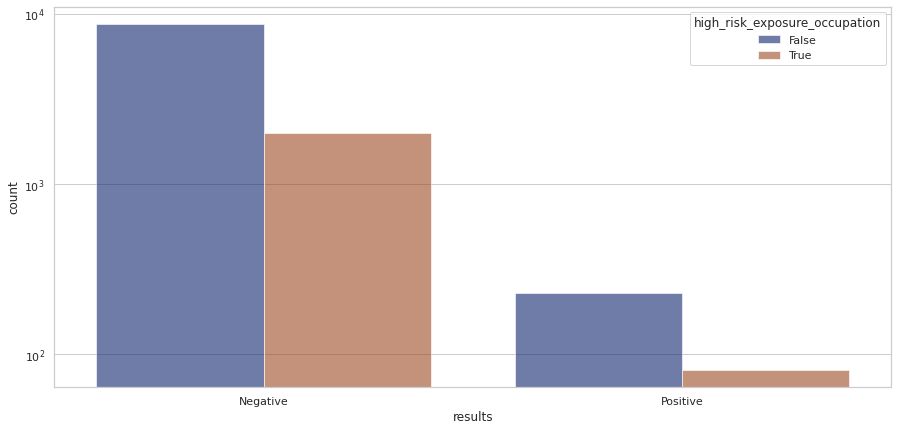

In [162]:
import seaborn as sb
sb.set_theme(style="whitegrid")

g = sb.countplot(
    data=data,
    x="results", hue="high_risk_exposure_occupation", palette="dark", alpha=.6,
)
g.set_yscale("log")


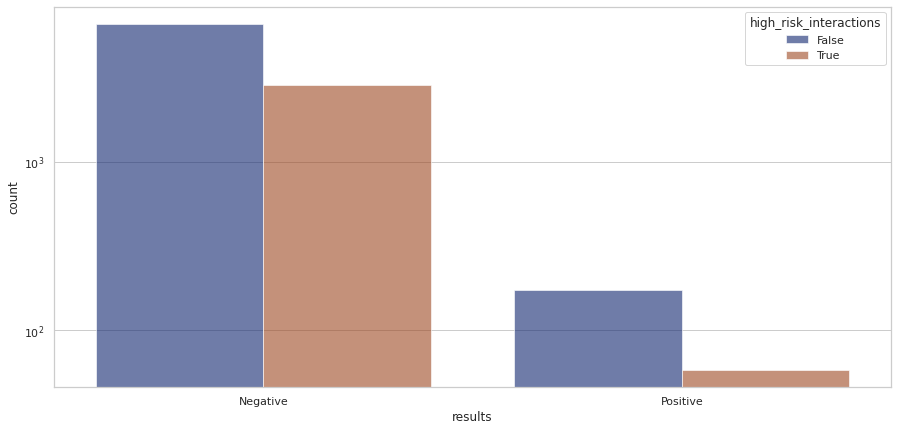

In [163]:

g = sb.countplot(
    data=data,
    x="results", hue="high_risk_interactions", palette="dark", alpha=.6,
)
g.set_yscale("log")

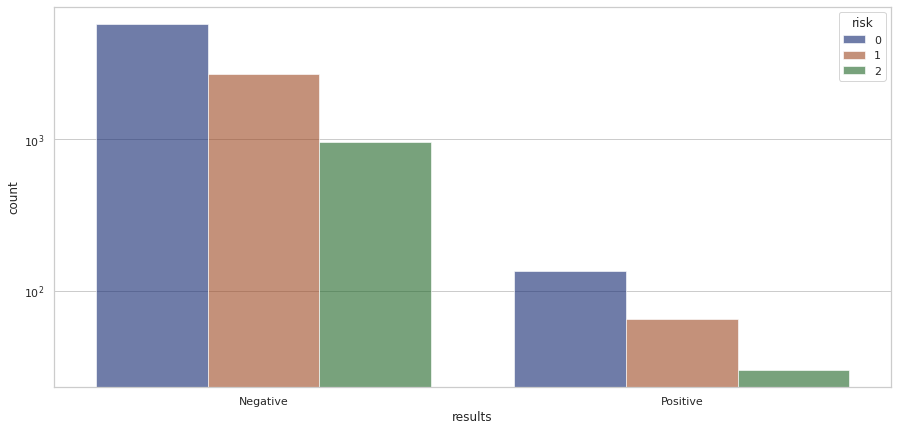

In [164]:
# Draw a nested barplot by species and sex
g = sb.countplot(
    data=data,
    x="results", hue="risk", palette="dark", alpha=.6,
)
g.set_yscale("log")

In [165]:
data[['risk', 'high_risk_interactions',
      'high_risk_exposure_occupation'] + SYMPTOMS] = data[['risk', 'high_risk_interactions', 'high_risk_exposure_occupation'] + SYMPTOMS].fillna(value=0)

# II. Load other data sources to enrich the model


In this part, we focus on adding exterior information to enrich the model and turn it into something that can be utilizable for people outside of the Carbon Health sampling frame. In particular, because Carbon Health had  a special way of choosing candidates (sampling bias), certain quantities are very specific to that particuliar dataset and could not be transferable to the more general population:

In particular, we want to use:
1. the FB public symptom survey dataset for __*prevalence estimates of Flu (ILI) symptoms*__, that could account for the ccategory of people who feel ill, but due for another disease than COVID. We also use this data as a way of correcting for __*potential under-ascertainment*__ of cases (under-reporting), the idea being that at the beginning of the pandemic, many more people could have been infected than reported, due to lack of tests.
2. the JHU, NYT and ECDC data on cases per day in order to inform what __*the prevalence among tested*__ should be each day 
3. Data on the US census to compute the __*local prevalence data among the general population*__ (for generalizing to anyone that could be interested in the dashboard, with or without antigen testing). See below for a more detailed explanation of why we need all of that data, and the different sampling bias that we would like to get rid off.
3. Meta data on _*the sensitivity of the different tests*_, in particular as a function of time
4. Meta data on the different risk factors (from publications and reported studies). This is particularly crucial, since we won't be able to train the model very well.







## A. FB Data (for the US)

Note: we only load the US data here since the Carbon Health data was collected in the US. For our visualization dashoard however, we also make full use of the rest of the data to be able to provide information to all interested participants.

In [166]:
fb_survey = pd.read_csv("/content/drive/My Drive/C3AI_code/FB_data/US_state_smoothed_FBsurvey.csv")

In [167]:
fb_survey.columns

Index(['date', 'state_code', 'gender', 'age_bucket', 'summed_n',
       'smoothed_pct_cli', 'smoothed_pct_ili',
       'smoothed_pct_cli_anosmia_ageusia', 'smoothed_pct_hh_cli',
       'smoothed_pct_cmnty_cli',
       ...
       'smoothed_pct_diabetes_weighted', 'smoothed_pct_cancer_weighted',
       'smoothed_pct_heart_disease_weighted',
       'smoothed_pct_high_blood_pressure_weighted',
       'smoothed_pct_asthma_weighted',
       'smoothed_pct_chronic_lung_disease_weighted',
       'smoothed_pct_kidney_disease_weighted',
       'smoothed_pct_autoimmune_disorder_weighted',
       'smoothed_pct_no_above_medical_conditions_weighted',
       'smoothed_pct_multiple_medical_conditions_weighted'],
      dtype='object', length=103)

In [168]:
print(np.unique(fb_survey.age_bucket))
print(np.unique(fb_survey.gender))

['18-34' '35-54' '55+' 'overall']
['female' 'male' 'overall']


Let us only focus on the pooled, weighted estimates, across gender and across age.

In [169]:
fb_survey = fb_survey.iloc[np.where((fb_survey.gender == "overall") * ( fb_survey.age_bucket == "overall"))]

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [170]:
fb_survey.head()

,date,state_code,gender,age_bucket,summed_n,smoothed_pct_cli,smoothed_pct_ili,smoothed_pct_cli_anosmia_ageusia,smoothed_pct_hh_cli,smoothed_pct_cmnty_cli,smoothed_pct_hh_fever,smoothed_pct_hh_sore_throat,smoothed_pct_hh_cough,smoothed_pct_hh_shortness_of_breath,smoothed_pct_hh_difficulty_breathing,smoothed_mean_hh_cli_ct,smoothed_mean_cmnty_cli_ct,smoothed_pct_self_fever,smoothed_pct_self_cough,smoothed_pct_self_shortness_of_breath,smoothed_pct_self_difficulty_breathing,smoothed_pct_self_tiredness_or_exhaustion,smoothed_pct_self_nasal_congestion,smoothed_pct_self_runny_nose,smoothed_pct_self_muscle_joint_aches,smoothed_pct_self_sore_throat,smoothed_pct_self_persistent_pain_pressure_in_chest,smoothed_pct_self_nausea_vomiting,smoothed_pct_self_diarrhea,smoothed_pct_self_anosmia_ageusia,smoothed_pct_self_other,smoothed_pct_self_none_of_above,smoothed_pct_self_multiple_symptoms,smoothed_pct_tested_and_positive,smoothed_pct_tested_and_negative,smoothed_pct_tested_no_result,smoothed_pct_could_not_get_tested,smoothed_pct_did_not_try_to_get_tested,smoothed_pct_worked_outside_home,smoothed_pct_avoid_contact_all_or_most_time,...,smoothed_pct_hh_difficulty_breathing_weighted,smoothed_mean_hh_cli_ct_weighted,smoothed_mean_cmnty_cli_ct_weighted,smoothed_pct_self_fever_weighted,smoothed_pct_self_cough_weighted,smoothed_pct_self_shortness_of_breath_weighted,smoothed_pct_self_difficulty_breathing_weighted,smoothed_pct_self_tiredness_or_exhaustion_weighted,smoothed_pct_self_nasal_congestion_weighted,smoothed_pct_self_runny_nose_weighted,smoothed_pct_self_muscle_joint_aches_weighted,smoothed_pct_self_sore_throat_weighted,smoothed_pct_self_persistent_pain_pressure_in_chest_weighted,smoothed_pct_self_nausea_vomiting_weighted,smoothed_pct_self_diarrhea_weighted,smoothed_pct_self_anosmia_ageusia_weighted,smoothed_pct_self_other_weighted,smoothed_pct_self_none_of_above_weighted,smoothed_pct_self_multiple_symptoms_weighted,smoothed_pct_tested_and_positive_weighted,smoothed_pct_tested_and_negative_weighted,smoothed_pct_tested_no_result_weighted,smoothed_pct_could_not_get_tested_weighted,smoothed_pct_did_not_try_to_get_tested_weighted,smoothed_pct_worked_outside_home_weighted,smoothed_pct_avoid_contact_all_or_most_time_weighted,smoothed_mean_outside_hh_contact_at_work_ct_weighted,smoothed_mean_outside_hh_contact_shopping_ct_weighted,smoothed_mean_outside_hh_contact_in_social_gatherings_ct_weighted,smoothed_pct_contact_covid_positive_weighted,smoothed_pct_diabetes_weighted,smoothed_pct_cancer_weighted,smoothed_pct_heart_disease_weighted,smoothed_pct_high_blood_pressure_weighted,smoothed_pct_asthma_weighted,smoothed_pct_chronic_lung_disease_weighted,smoothed_pct_kidney_disease_weighted,smoothed_pct_autoimmune_disorder_weighted,smoothed_pct_no_above_medical_conditions_weighted,smoothed_pct_multiple_medical_conditions_weighted
2190,2020-11-01,ak,overall,overall,554,0.5486,0.5486,1.8247,1.0848,30.1013,1.2653,5.2560,14.4404,3.4296,2.8881,0.2212,3010.1253,0.9117,9.3037,3.2823,1.4582,15.1509,14.4045,13.4714,12.4068,4.0095,1.8139,1.8213,3.0914,1.4584,2.9117,63.3520,22.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.2378,0.2341,4498.2210,0.7953,9.6371,4.3844,1.4030,17.9170,13.5831,16.1126,11.0996,4.8019,3.4752,3.3172,3.5418,1.7817,2.7517,63.3203,23.5220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1214,6.8741,4.8795,2.9845,0.0,4.5353,3.6869,28.1022,15.0337,3.0424,0.6484,7.0394,53.1089,24.9124
2191,2020-10-31,ak,overall,overall,548,0.5525,0.5525,1.8383,1.0967,29.8790,1.2792,5.8610,14.0511,3.4672,2.7372,0.2274,3043.0937,0.7350,9.0237,3.1315,1.2874,14.5571,13.9872,12.6767,11.7788,3.6778,1.6492,2.0194,3.4860,1.4702,3.6735,64.1156,21.1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.4762,0.2510,4547.5094,0.6606,9.9426,4.6474,1.6214,18.3674,14.0913,16.1982,11.4513,5.0461,3.3743,3.9619,4.3630,1.9267,3.4513,62.5333,23.8023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.3780,5.8516,4.9944,3.1799,0.0,4.2421,4.7713,28.5035,14.8006,2.4597,0.8570,6.4651,52.1548,25.0195
2192,2020-10-30,ak,overall,overall,548,0.7350,0.5525,2.

In [171]:
fb_survey['date'] = pd.to_datetime(fb_survey['date'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


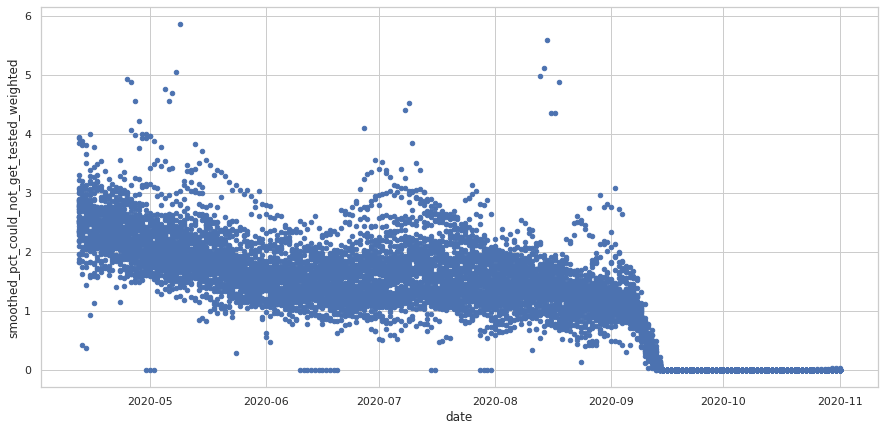

In [172]:
fb_survey.plot(kind = "scatter", x= "date", y= "smoothed_pct_could_not_get_tested_weighted" )

In [173]:
fb_survey['prev_among_tested'] = fb_survey.smoothed_pct_tested_and_positive_weighted/(fb_survey.smoothed_pct_tested_and_positive_weighted +
                                                     fb_survey.smoothed_pct_tested_and_negative_weighted + 
                                                     fb_survey.smoothed_pct_tested_no_result_weighted)

In [174]:
fb_survey['prev_among_tested'].mean()

0.10321690887851388

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


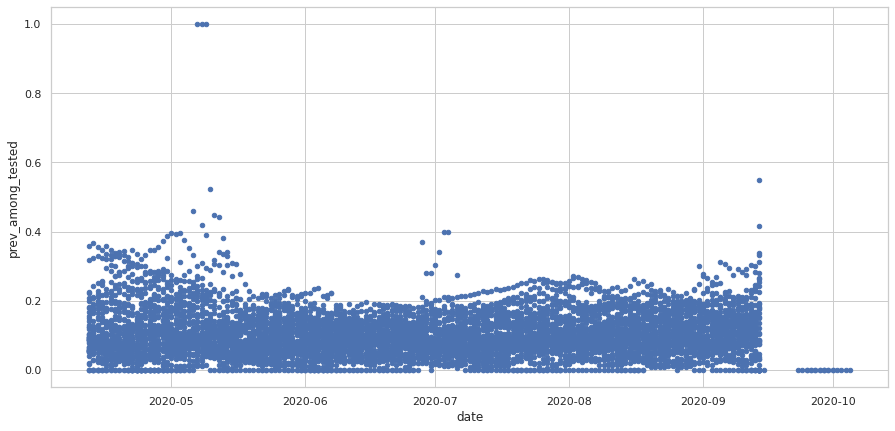

In [175]:
fb_survey.plot(kind = "scatter", x= "date", y= "prev_among_tested" )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


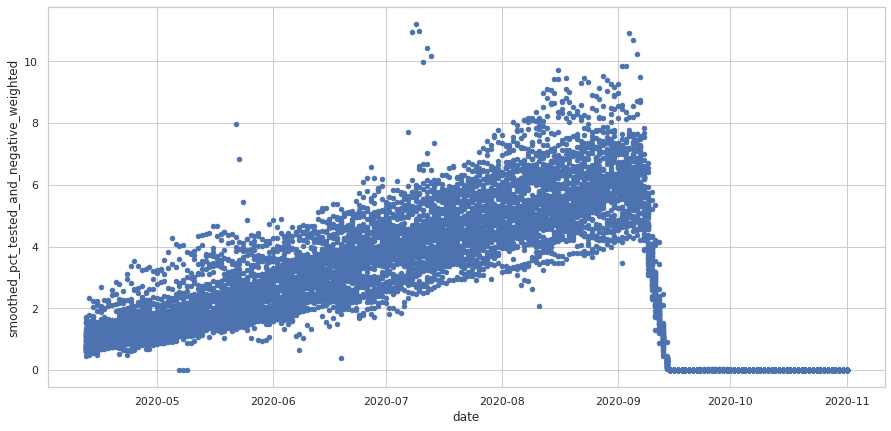

In [176]:
fb_survey.plot(kind = "scatter", x= "date", y= "smoothed_pct_tested_and_negative_weighted" )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


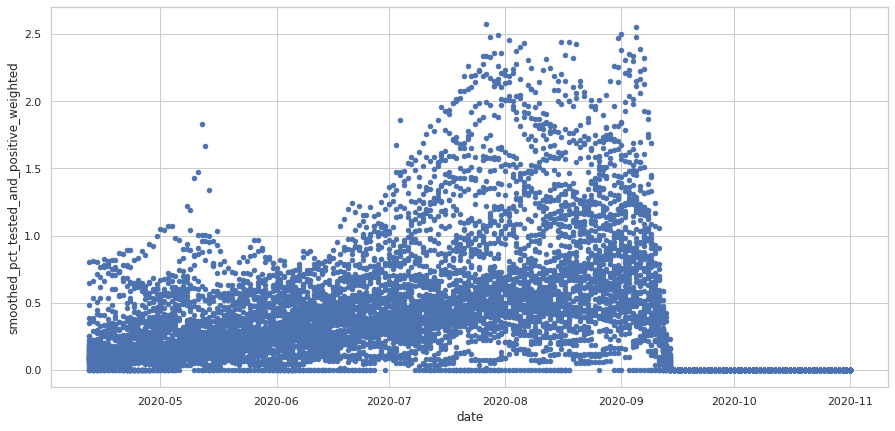

In [177]:
fb_survey.plot(kind = "scatter", x= "date", y= "smoothed_pct_tested_and_positive_weighted" )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


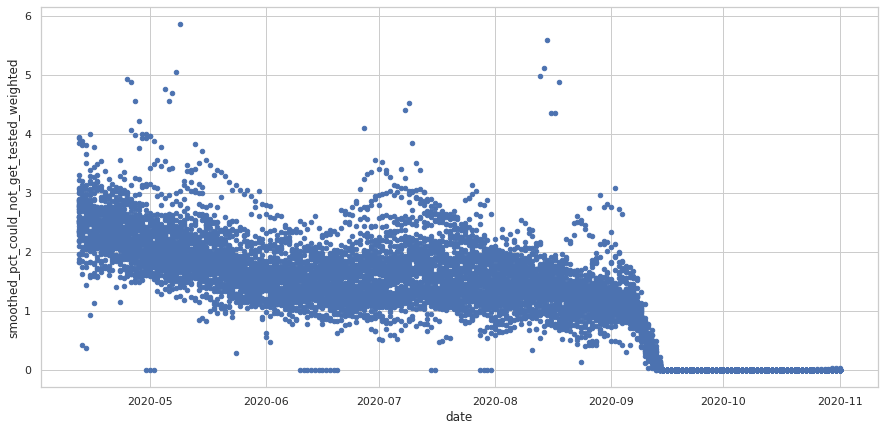

In [178]:
fb_survey.plot(kind = "scatter", x= "date", y= "smoothed_pct_could_not_get_tested_weighted" ) 

As we can see, up to 2 % of people wanted to get tested in May, but had been unable. This means that a considerable larger proportion of people had a substantial risk of being infected (people supposedly want to get tested for a reason --- whether because they have symptoms or because they were in the vicinity of confirmed cases).

Why would we want to use this dataset?
At the beginning of the pandemic, the testing capacities were rather restricted. Hence, there would typically be an underreporting of cases that we need to adjust for. This can also be seen by looking at the Case Fatality Ratio (CFR), which decreased over time, probably due to that same testing bias. But, as we will see in the following subsection, the CFR changed quite dramatically through time, and it thus hard to find a principled baseline estimate for that particular parameters.

## B. Sensitivity estimates

Sources:
- Hongyu Wang, Jingwen Ai, Michael J. Loeffelholz, Yi-Wei Tang & Wenhong Zhang (2020) Meta-analysis of diagnostic performance of serology tests for COVID-19: impact of assay design and post-symptom-onset intervals, Emerging Microbes & Infections, 9:1, 2200-2211, DOI: 10.1080/22221751.2020.1826362
: https://www.tandfonline.com/doi/full/10.1080/22221751.2020.1826362

In [179]:
SYMPTOMS

['ctab',
 'rhonchi',
 'wheezes',
 'cough',
 'fever',
 'sob',
 'diarrhea',
 'fatigue',
 'headache',
 'loss_of_smell',
 'loss_of_taste',
 'runny_nose',
 'muscle_sore',
 'sore_throat']

In [180]:
SYMPTOMS_QUANT = {'cough_severity':[4, ['pi', 'alpha_dir']], 
                  'symptoms_severity':[4, ['pi', 'alpha_dir']],
                  'howShortOfBreath':[4, ['pi', 'alpha_dir']],
                  'fever_severity':[4, ['pi', 'alpha_dir']]}


SENSITIVITY = {'serology_asymptomatic': [0.694, 0.519, 0.837],
               'serology_2-10 days': [0.811, 0.724, 0.881],
               'serology_11-20 days': [0.935, 0.843, 0.982],
               'serology_21+ days': [0.99, 0.98, 1.0],
               'elisa_asymptomatic': [0.694, 0.519, 0.837],
               'elisa_2-10 days': [0.811, 0.724, 0.881],
               'elisa_11-20 days': [0.935, 0.843, 0.982],
               'elisa_21+ days': [0.99, 0.98, 1.0],
               'rtPCR_asymptomatic': [0.694, 0.519, 0.837],
               'rtPCR_2-10 days': [0.811, 0.724, 0.881],
               'rtPCR_11-20 days': [0.935, 0.843, 0.982],
               'rtPCR_21+ days': [0.99, 0.98, 1.0],
               #'missing': [np.nan, np.nan, np.nan]
               }
SPECIFICITY = {'asymptomatic': [0.0002, 0.0001, 0.0003],
               '2-10 days': [0.0002, 0.0001, 0.0003],
               '11-20 days': [0.0002, 0.0001, 0.0003],
               '21+ days': [0.0002, 0.0001, 0.0003],
               #'missing': [np.nan, np.nan, np.nan]
               }

SYMPTOMS_PRIORS = {'asymptomatic': [0.0002, 0.0001, 0.0003],
                  '2-10 days': [0.0002, 0.0001, 0.0003],
                  '11-20 days': [0.0002, 0.0001, 0.0003],
                  '21+ days': [0.0002, 0.0001, 0.0003]
                  }

In [181]:
confusion_matrix(data, "type_test", "swab_type")

swab_type,Nasal,Nasopharyngeal
type_test,,
Rapid COVID-19 Test,1212,2502
SARS COV 2 RNA RTPCR,2,352
SARS COV2 NAAT,136,2934
SARS CoV w/CoV 2 RNA,0,396
"SARS-CoV-2, NAA",3212,423


## C. The data lake incidence dataset, to compute the prevalence 

To achieve this, we use the c3_ai APIs, as decribed in the starter notebook.


### i. Case Incidence information

In [182]:
state_from_location = lambda x: "_".join(x.split('_')[-2:]).replace("_UnitedStates", "")

def reshapeTimeseries(timeseries_df):
    reshaped_ts = pd.melt(
        timeseries_df, 
        id_vars=['dates'], 
        value_vars=[x for x in timeseries_df.columns if re.match('.*\.data', x)]
    ).rename(columns={"value": "data", "dates": "date"})

    reshaped_ts["state"] = (
        reshaped_ts["variable"]
        .str.replace("\..*", "")
        .apply(state_from_location)
    )

    reshaped_ts["metric"] = (
        reshaped_ts["variable"]
        .str.replace(".*UnitedStates\.", "")
        .str.replace("\..*", "")
    )
    

    return reshaped_ts

In [183]:
today = '2020-11-06'
states = [
    'Alabama_UnitedStates','Alaska_UnitedStates','Arizona_UnitedStates',
    'Arkansas_UnitedStates','California_UnitedStates','Colorado_UnitedStates',
    'Connecticut_UnitedStates','Delaware_UnitedStates','DistrictofColumbia_UnitedStates',
    'Florida_UnitedStates','Georgia_UnitedStates','Hawaii_UnitedStates',
    'Idaho_UnitedStates','Illinois_UnitedStates','Indiana_UnitedStates',
    'Iowa_UnitedStates','Kansas_UnitedStates','Kentucky_UnitedStates',
    'Louisiana_UnitedStates','Maine_UnitedStates','Maryland_UnitedStates',
    'Massachusetts_UnitedStates','Michigan_UnitedStates','Minnesota_UnitedStates',
    'Mississippi_UnitedStates','Missouri_UnitedStates','Montana_UnitedStates',
    'Nebraska_UnitedStates','Nevada_UnitedStates','NewHampshire_UnitedStates',
    'NewJersey_UnitedStates','NewMexico_UnitedStates','NewYork_UnitedStates',
    'NorthCarolina_UnitedStates','NorthDakota_UnitedStates','Ohio_UnitedStates',
    'Oklahoma_UnitedStates','Oregon_UnitedStates','Pennsylvania_UnitedStates',
    'PuertoRico_UnitedStates','RhodeIsland_UnitedStates','SouthCarolina_UnitedStates',
    'SouthDakota_UnitedStates','Tennessee_UnitedStates','Texas_UnitedStates',
    'Utah_UnitedStates','Vermont_UnitedStates','Virginia_UnitedStates',
    'Washington_UnitedStates','WestVirginia_UnitedStates','Wisconsin_UnitedStates',
    'Wyoming_UnitedStates'
]


metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : states,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

In [184]:
complete_timeseries.head()

,dates,Alabama_UnitedStates.JHU_ConfirmedCases.data,Alabama_UnitedStates.JHU_ConfirmedCases.missing,Alabama_UnitedStates.JHU_ConfirmedDeaths.data,Alabama_UnitedStates.JHU_ConfirmedDeaths.missing,Colorado_UnitedStates.JHU_ConfirmedCases.data,Colorado_UnitedStates.JHU_ConfirmedCases.missing,Colorado_UnitedStates.JHU_ConfirmedDeaths.data,Colorado_UnitedStates.JHU_ConfirmedDeaths.missing,Florida_UnitedStates.JHU_ConfirmedCases.data,Florida_UnitedStates.JHU_ConfirmedCases.missing,Florida_UnitedStates.JHU_ConfirmedDeaths.data,Florida_UnitedStates.JHU_ConfirmedDeaths.missing,Connecticut_UnitedStates.JHU_ConfirmedCases.data,Connecticut_UnitedStates.JHU_ConfirmedCases.missing,Connecticut_UnitedStates.JHU_ConfirmedDeaths.data,Connecticut_UnitedStates.JHU_ConfirmedDeaths.missing,DistrictofColumbia_UnitedStates.JHU_ConfirmedCases.data,DistrictofColumbia_UnitedStates.JHU_ConfirmedCases.missing,DistrictofColumbia_UnitedStates.JHU_ConfirmedDeaths.data,DistrictofColumbia_UnitedStates.JHU_ConfirmedDeaths.missing,Alaska_UnitedStates.JHU_ConfirmedCases.data,Alaska_UnitedStates.JHU_ConfirmedCases.missing,Alaska_UnitedStates.JHU_ConfirmedDeaths.data,Alaska_UnitedStates.JHU_ConfirmedDeaths.missing,California_UnitedStates.JHU_ConfirmedCases.data,California_UnitedStates.JHU_ConfirmedCases.missing,California_UnitedStates.JHU_ConfirmedDeaths.data,California_UnitedStates.JHU_ConfirmedDeaths.missing,Arkansas_UnitedStates.JHU_ConfirmedCases.data,Arkansas_UnitedStates.JHU_ConfirmedCases.missing,Arkansas_UnitedStates.JHU_ConfirmedDeaths.data,Arkansas_UnitedStates.JHU_ConfirmedDeaths.missing,Arizona_UnitedStates.JHU_ConfirmedCases.data,Arizona_UnitedStates.JHU_ConfirmedCases.missing,Arizona_UnitedStates.JHU_ConfirmedDeaths.data,Arizona_UnitedStates.JHU_ConfirmedDeaths.missing,Delaware_UnitedStates.JHU_ConfirmedCases.data,Delaware_UnitedStates.JHU_ConfirmedCases.missing,Delaware_UnitedStates.JHU_ConfirmedDeaths.data,...,Utah_UnitedStates.JHU_ConfirmedCases.data,Utah_UnitedStates.JHU_ConfirmedCases.missing,Utah_UnitedStates.JHU_ConfirmedDeaths.data,Utah_UnitedStates.JHU_ConfirmedDeaths.missing,Vermont_UnitedStates.JHU_ConfirmedCases.data,Vermont_UnitedStates.JHU_ConfirmedCases.missing,Vermont_UnitedStates.JHU_ConfirmedDeaths.data,Vermont_UnitedStates.JHU_ConfirmedDeaths.missing,WestVirginia_UnitedStates.JHU_ConfirmedCases.data,WestVirginia_UnitedStates.JHU_ConfirmedCases.missing,WestVirginia_UnitedStates.JHU_ConfirmedDeaths.data,WestVirginia_UnitedStates.JHU_ConfirmedDeaths.missing,Tennessee_UnitedStates.JHU_ConfirmedCases.data,Tennessee_UnitedStates.JHU_ConfirmedCases.missing,Tennessee_UnitedStates.JHU_ConfirmedDeaths.data,Tennessee_UnitedStates.JHU_ConfirmedDeaths.missing,Texas_UnitedStates.JHU_ConfirmedCases.data,Texas_UnitedStates.JHU_ConfirmedCases.missing,Texas_UnitedStates.JHU_ConfirmedDeaths.data,Texas_UnitedStates.JHU_ConfirmedDeaths.missing,Washington_UnitedStates.JHU_ConfirmedCases.data,Washington_UnitedStates.JHU_ConfirmedCases.missing,Washington_UnitedStates.JHU_ConfirmedDeaths.data,Washington_UnitedStates.JHU_ConfirmedDeaths.missing,SouthDakota_UnitedStates.JHU_ConfirmedCases.data,SouthDakota_UnitedStates.JHU_ConfirmedCases.missing,SouthDakota_UnitedStates.JHU_ConfirmedDeaths.data,SouthDakota_UnitedStates.JHU_ConfirmedDeaths.missing,Virginia_UnitedStates.JHU_ConfirmedCases.data,Virginia_UnitedStates.JHU_ConfirmedCases.missing,Virginia_UnitedStates.JHU_ConfirmedDeaths.data,Virginia_UnitedStates.JHU_ConfirmedDeaths.missing,Wyoming_UnitedStates.JHU_ConfirmedCases.data,Wyoming_UnitedStates.JHU_ConfirmedCases.missing,Wyoming_UnitedStates.JHU_ConfirmedDeaths.data,Wyoming_UnitedStates.JHU_ConfirmedDeaths.missing,Wisconsin_UnitedStates.JHU_ConfirmedCases.data,Wisconsin_UnitedStates.JHU_ConfirmedCases.missing,Wisconsin_UnitedStates.JHU_ConfirmedDeaths.data,Wisconsin_UnitedStates.JHU_ConfirmedDeaths.missing
0,2020-02-15,0,100,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [185]:
state_timeseries = reshapeTimeseries(complete_timeseries)
state_timeseries.head()

,date,variable,data,state,metric
0,2020-02-15,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
1,2020-02-16,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
2,2020-02-17,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
3,2020-02-18,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
4,2020-02-19,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases


In [186]:
state_timeseries[["data"]] = state_timeseries[["data"]].apply(pd.to_numeric) 

In [187]:
np.unique(state_timeseries[["metric"]])

array(['JHU_ConfirmedCases', 'JHU_ConfirmedDeaths'], dtype=object)

In [188]:
state_timeseries_deaths = state_timeseries.iloc[np.where(state_timeseries.metric == 'JHU_ConfirmedDeaths')[0]]
state_timeseries_deaths.rename(columns={ 'data': 'deaths'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [189]:
state_timeseries = state_timeseries.iloc[np.where(state_timeseries.metric == 'JHU_ConfirmedCases')[0]]
state_timeseries.rename(columns={ 'data': 'cases'}, inplace=True)

In [190]:
state_timeseries

,date,variable,cases,state,metric
0,2020-02-15,Alabama_UnitedStates.JHU_ConfirmedCases.data,0.0,Alabama,JHU_ConfirmedCases
1,2020-02-16,Alabama_UnitedStates.JHU_ConfirmedCases.data,0.0,Alabama,JHU_ConfirmedCases
2,2020-02-17,Alabama_UnitedStates.JHU_ConfirmedCases.data,0.0,Alabama,JHU_ConfirmedCases
3,2020-02-18,Alabama_UnitedStates.JHU_ConfirmedCases.data,0.0,Alabama,JHU_ConfirmedCases
4,2020-02-19,Alabama_UnitedStates.JHU_ConfirmedCases.data,0.0,Alabama,JHU_ConfirmedCases
...,...,...,...,...,...
27290,2020-11-01,Wisconsin_UnitedStates.JHU_ConfirmedCases.data,228862.0,Wisconsin,JHU_ConfirmedCases
27291,2020-11-02,Wisconsin_UnitedStates.JHU_ConfirmedCases.data,232295.0,Wisconsin,JHU_ConfirmedCases
27292,2020-11-03,Wisconsin_UnitedStates.JHU_ConfirmedCases.data,238066.0,Wisconsin,JHU_ConfirmedCases
27293,2020-11-04,Wisconsin_UnitedStates.JHU_ConfirmedCases.data,244002.0,Wisconsin,JHU_ConfirmedCases


In [191]:
state_timeseries = state_timeseries[['date','state', 'cases']].merge(state_timeseries_deaths[['date','state', 'deaths']], on = ["date", "state"])

In [192]:
#### Compute the CFR
state_timeseries['CFR'] = state_timeseries['deaths']/ state_timeseries['cases']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


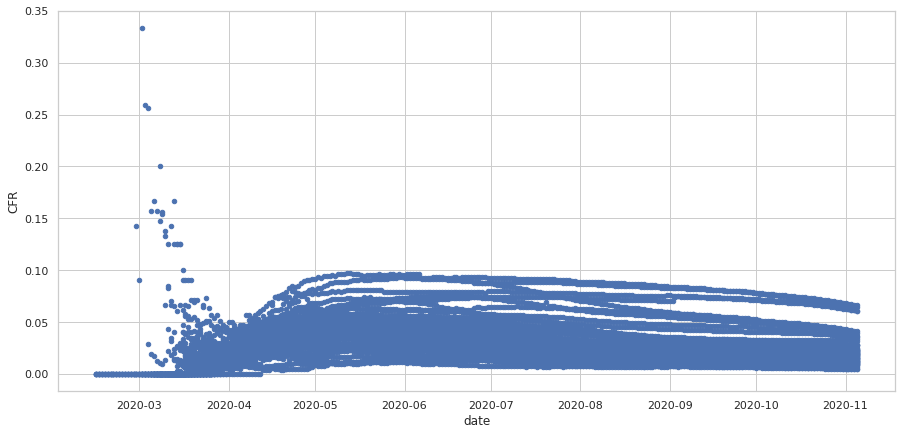

In [193]:
state_timeseries.plot(kind = "scatter", x= "date", y= "CFR" )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730.]), <a list of 9 Text major ticklabel objects>)

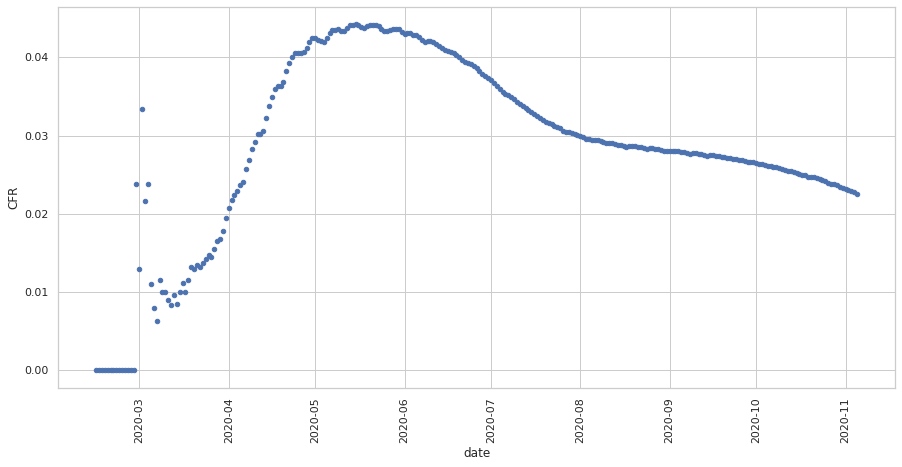

In [194]:
(state_timeseries.groupby(['date']).mean().reset_index()).plot(kind = "scatter",x='date', y= "CFR")
plt.xticks(rotation=90)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730.]), <a list of 9 Text major ticklabel objects>)

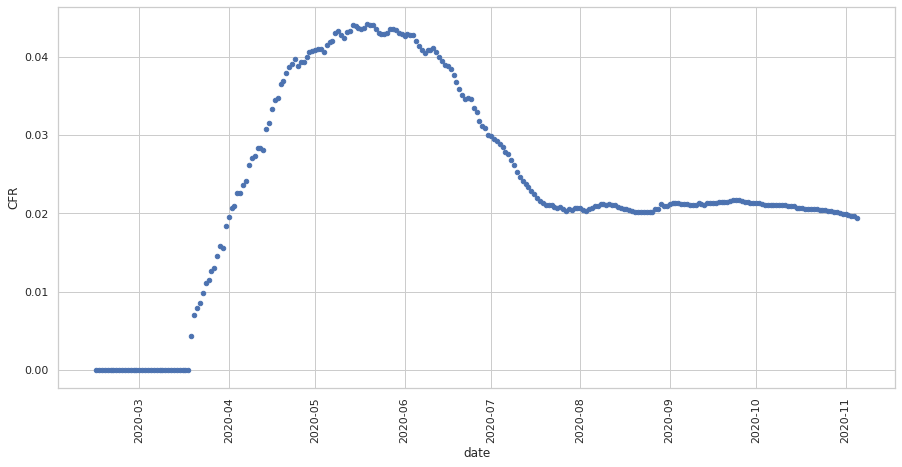

In [195]:
(state_timeseries.groupby(['date']).median().reset_index()).plot(kind = "scatter",x='date', y= "CFR")
plt.xticks(rotation=90)

The real CFR thus seems to be coming to an equilibrium, and to be around 2.5 in the case of the US.  Interestingly, the mean has not stabilized over the past few months (but the median has, see next plot) --- making us a little uncomfortable in using this as a baseline to adjust for case under-reporting. Which is why we are going to go here with the FB survey data to estimate this under-reporting.



We still need the cases data to estimate the local prevalence. Let us thus transform the datasamples.

In [196]:
### Convert the cumulative counts into incident cases 
state_timeseries_diff = state_timeseries.pivot_table(values='cases', index='date', columns='state')

In [197]:
state_timeseries_diff

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,PuertoRico,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-02-16,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-02-17,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-02-18,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-02-19,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,193985.0,16729.0,247473.0,113057.0,935878.0,109887.0,71207.0,25126.0,17369.0,807412.0,361982.0,15154.0,65088.0,423527.0,182108.0,130974.0,83198.0,108642.0,183341.0,6711.0,146145.0,159707.0,197406.0,150672.0,120500.0,188325.0,33495.0,71666.0,101477.0,11214.0,239629.0,47232.0,509735.0,276692.0,45043.0,219000.0,124111.0,45429.0,214416.0,66661.0,32874.0,178023.0,47324.0,261426.0,936816.0,116510.0,2196.0,182392.0,108315.0,24883.0,228862.0,13723.0
2020-11-02,194892.0,17081.0,248139.0,113641.0,940411.0,112124.0,73858.0,25311.0,17438.0,812063.0,362921.0,15231.0,65845.0,429749.0,185185.0,132516.0,85280.0,109670.0,183616.0,6798.0,146995.0,160549.0,204326.0,153620.0,120865.0,191223.0,34252.0,72620.0,102114.0,11320.0,240997.0,48104.0,511368.0,278028.0,46015.0,221909.0,125195.0,45978.0,217243.0,68172.0,34120.0,178917.0,47850.0,264587.0,942303.0,117706.0,2219.0,183418.0,109354.0,25238.0,232295.0,14167.0
2020-11-03,195929.0,17470.0,249818.0,114519.0,945401.0,114709.0,74843.0,25426.0,17524.0,816700.0,364589.0,15318.0,67024.0,436265.0,188066.0,134326.0,86290.0,111379.0,184769.0,6925.0,147766.0,161585.0,207763.0,157096.0,121509.0,193441.0,35159.0,74060.0,103025.0,11448.0,242825.0,49240.0,513689.0,280377.0,47187.0,226138.0,126526.0,46460.0,220074.0,68943.0,34543.0,179952.0,48854.0,266357.0,950302.0,119375.0,2237.0,184679.0,110011.0,25596.0,238066.0,14621.0


In [198]:
state_timeseries_diff = state_timeseries_diff.diff(axis=0)

In [199]:
state_timeseries_diff.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,PuertoRico,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
### We take the rolling 7-day average (standard in the literature,
### to get rid of the weekly cyclicity and weekend effects)
state_timeseries_diff = state_timeseries_diff.rolling(7).mean()
state_timeseries_diff = state_timeseries_diff.iloc[7:,:]

In [201]:
state_timeseries_diff.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,PuertoRico,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-22,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-25,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-26,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
### Let us now threshold the entries to 0 (to get rid of the
### reporting errors that create negative counts)
ind_u, v_u = np.where(state_timeseries_diff <0 )
for i in range(len(ind_u)):
  state_timeseries_diff.iloc[ind_u[i], v_u[i]] = 0

### ii. Demographics

In [203]:
### Extract State Population information to compute the prevalence

In [204]:
### Extract State Population information to compute the prevalence
population_limits = (
    f"contains(parent, 'UnitedStates') &&" # US data
    "(populationAge == '>=65' || populationAge == 'Total' || populationAge == '>=18') && " # Limit age groups
    "gender == 'Male/Female' && year == 2018 && origin == 'United States Census'" # From 2018 estimates
)

census = c3aidatalake.fetch(
    "populationdata",
    {
      "spec": {
        "filter": population_limits
      }
    },
    get_all = True
)

census['state'] = census['parent.id'].apply(state_from_location)
census = census.rename(columns={'parent.id': 'location'})

census_cols = [
    "populationAge",
    "value",
    "location",
    "state"
]

census_by_state = (
    census[census_cols]
    .loc[census.state.isin(map(lambda x: x.replace("_UnitedStates", ""), states))]
    .groupby(["state", "populationAge"])['value']
    .sum()
    .unstack("populationAge")
    .reset_index()
)

census_by_state.columns = ['state', 'over18', 'over65', 'total']
census_by_state['olderPerc'] = census_by_state.over65 * 100 / census_by_state.total
census_by_state['youngerPerc'] = (census_by_state.total - census_by_state.over18) * 100 / census_by_state.total

In [205]:
census_by_state

,state,over18,over65,total,olderPerc,youngerPerc
0,Alabama,3798031.0,826894.0,4887871.0,16.917263,22.296824
1,Alaska,588192.0,93336.0,781305.0,11.946167,24.716724
2,Arizona,5528989.0,1258250.0,7171646.0,17.544787,22.904881
3,Arkansas,2310645.0,511827.0,3013825.0,16.982638,23.331813
4,California,30567090.0,5669025.0,39557045.0,14.331265,22.726559
5,Colorado,4430329.0,808229.0,5695564.0,14.190500,22.214394
6,Connecticut,2837472.0,615121.0,3572665.0,17.217427,20.578280
7,Delaware,763555.0,181086.0,967171.0,18.723266,21.052740
8,DistrictofColumbia,574961.0,85303.0,702455.0,12.143554,18.149775
9,Florida,17070244.0,4358071.0,21299325.0,20.461076,19.855470


In [206]:
for s in list(state_timeseries_diff.columns):
  ind_census = np.where(census_by_state.state == s)[0][0]
  state_timeseries_diff[s + '_pct'] = state_timeseries_diff[s] / census_by_state.iloc[ind_census]["total"]

In [207]:
state_timeseries_diff

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,PuertoRico,...,Idaho_pct,Illinois_pct,Indiana_pct,Iowa_pct,Kansas_pct,Kentucky_pct,Louisiana_pct,Maine_pct,Maryland_pct,Massachusetts_pct,Michigan_pct,Minnesota_pct,Mississippi_pct,Missouri_pct,Montana_pct,Nebraska_pct,Nevada_pct,NewHampshire_pct,NewJersey_pct,NewMexico_pct,NewYork_pct,NorthCarolina_pct,NorthDakota_pct,Ohio_pct,Oklahoma_pct,Oregon_pct,Pennsylvania_pct,PuertoRico_pct,RhodeIsland_pct,SouthCarolina_pct,SouthDakota_pct,Tennessee_pct,Texas_pct,Utah_pct,Vermont_pct,Virginia_pct,Washington_pct,WestVirginia_pct,Wisconsin_pct,Wyoming_pct
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-22,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-23,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-24,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-25,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-26,0.000000,0.000000,0.000000,0.000000,0.2857

In [208]:
### Compute prevalence for Carbon Health (CH) (aggregate NY CA Alabama and Florida),
### because we have no granular information on where each test comes from
### We take the mean (rather than a weighted mean) because there is no way of knowing 
### what the distribution of CH is like among these states
prevalence = pd.DataFrame(state_timeseries_diff[['Alabama', 'Florida', 'NewYork', 'California']].sum(1),
                          columns=['prevalence'])

In [209]:
ind_census = census_by_state.apply(lambda x: x.state in ['Alabama', 'Florida', 'NewYork', 'California'],
                                   axis = 1)

In [210]:
prevalence = prevalence/census_by_state.loc[ind_census].sum(0)['total']

In [211]:
prevalence

,prevalence
date,
2020-02-22,3.350055e-09
2020-02-23,3.350055e-09
2020-02-24,3.350055e-09
2020-02-25,3.350055e-09
2020-02-26,3.350055e-09
...,...
2020-11-01,1.372836e-04
2020-11-02,1.412149e-04
2020-11-03,1.431093e-04


Now that we have the different prevalences, we merge this with the facebook data for the four states that we are considering.

In [212]:
## Make the state code match
state_code_eq = {'ak' : 'Alaska', 'al' : 'Alabama', 'ar': 'Arkansas',
                 'az':'Arizona', 'ca':'California', 'co':'Colorado', 
                 'ct':'Connecticut', 'dc':'DistrictofColumbia', 'de':'Delaware',
                 'fl':'Florida', 'ga':'Georgia','hi':'Hawaii', 'ia':'Iowa',
                 'id':'Idaho', 'il':'Illinois', 'in':'Indiana','ks':'Kansas', 
                 'ky':'Kentucky', 'la':'Louisiana', 'ma':'Massachusetts',
                 'md':'Maryland', 'me':'Maine', 'mi': 'Missouri', 'mn':'Minnesota',
                 'mo':'Missouri', 'ms':'Mississippi', 'mt':'Montana', 
                 'nc':'NorthCarolina', 'nd':'NorthDakota', 'ne':'Nebraska', 
                 'nh': 'NewHampshire', 'nj':'NewJersey', 'nm':'NewMexico',
                 'nv':'Nevada', 'ny':'NewYork', 'oh':'Ohio', 'ok':'Oklahoma',
                 'or':'Oregon', 'pa':'Pennsylvania', 'pr':'PuertoRico',
                 'ri':'RhodeIsland', 'sc': 'SouthCarolina', 'sd':'SouthDakota',
                 'tn':'Tennessee', 'tx':'Texas', 'ut':'Utah', 'va':'Virginia',
                 'vt':'Vermont', 'wa':'Washington', 'wv':'WestVirginia',
                 'wi':'Wisconsin', 'wy':'Wyoming'}

In [213]:
fb_survey['state'] = fb_survey.apply(lambda x: state_code_eq[x.state_code], axis=1)

In [214]:
fb_survey = fb_survey[[ 'date', 'state','state_code',
                       'smoothed_pct_cli_weighted',
                       'smoothed_pct_ili_weighted','prev_among_tested',
                       'smoothed_pct_could_not_get_tested_weighted']].merge(state_timeseries, on=['date', 'state'])

In [215]:
fb_survey2 = fb_survey.loc[fb_survey['state_code'].apply(lambda x:  (x == 'al') + (x== 'ny') + (x == 'ca') +(x == 'fl')) > 0]
fb_survey2 = fb_survey2.groupby(['date']).mean()

In [216]:
  reshaped_ts = pd.melt(
        state_timeseries_diff.reset_index(), 
        id_vars=['date'], 
        value_vars=[x for x in  state_timeseries_diff.columns]
    ).rename(columns={"value": "data", "date": "date"})

In [217]:
  reshaped_ts.apply(lambda x: x.state.split("_")[0], axis=1)

0        Alabama
1        Alabama
2        Alabama
3        Alabama
4        Alabama
          ...   
26827    Wyoming
26828    Wyoming
26829    Wyoming
26830    Wyoming
26831    Wyoming
Length: 26832, dtype: object

In [218]:
  reshaped_ts.rename(columns={'state':'state_code'}, inplace=True)

In [219]:
  reshaped_ts['state'] =   reshaped_ts.apply(lambda x: x.state_code.split("_")[0], axis=1)

In [220]:
  reshaped_ts['variable'] =   reshaped_ts.apply(lambda x: (len(x.state_code.split("_")) == 1) * 'sum' +
                                             (len(x.state_code.split("_")) == 2) * 'pct', axis=1)

In [221]:
reshaped_ts = reshaped_ts.merge(fb_survey, on=['state','date'])

In [222]:
data['date_test_taken'] = pd.to_datetime(data['date_test_taken'])

In [223]:
prevalence

,prevalence
date,
2020-02-22,3.350055e-09
2020-02-23,3.350055e-09
2020-02-24,3.350055e-09
2020-02-25,3.350055e-09
2020-02-26,3.350055e-09
...,...
2020-11-01,1.372836e-04
2020-11-02,1.412149e-04
2020-11-03,1.431093e-04


In [224]:
data = data.merge(prevalence, how="left", left_on="date_test_taken", right_index=True )
print(data.shape)

(11169, 54)


In [225]:
fb_survey2.columns

Index(['smoothed_pct_cli_weighted', 'smoothed_pct_ili_weighted',
       'prev_among_tested', 'smoothed_pct_could_not_get_tested_weighted',
       'cases', 'deaths', 'CFR'],
      dtype='object')

In [226]:
data = data.merge(fb_survey2[['smoothed_pct_cli_weighted', 'prev_among_tested',
                              'smoothed_pct_ili_weighted', 'smoothed_pct_could_not_get_tested_weighted']],
                  how="left", left_on="date_test_taken",right_index=True )

In [227]:
data['smoothed_pct_ili_weighted']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1441    0.539275
1442    0.539275
1443    0.539275
1444    0.539275
1445    0.539275
Name: smoothed_pct_ili_weighted, Length: 11169, dtype: float64

### iii. Use all the information to enrich the dataset

In [228]:
### Add results to data
percentage_asymptomatic = 0.16
data['p01'] = data['smoothed_pct_ili_weighted'] * 0.01  ### need to convert the percentage into something from 0 to 1
data['p11'] = data['prevalence'] + data['prev_among_tested'] * data['smoothed_pct_could_not_get_tested_weighted'] * 0.01 ### accounts for under-reporint
data['p10'] = percentage_asymptomatic * data['p11'] ### nb of cases that are asymptomatic 
data['p00'] = 1.0 - data['p01']  - data['p10'] - data['p11']

In [229]:
data['p00']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1441    0.992411
1442    0.992411
1443    0.992411
1444    0.992411
1445    0.992411
Name: p00, Length: 11169, dtype: float64

In [230]:
percentage_asymptomatic = 0.16
data['p01'] = data['smoothed_pct_ili_weighted'] * 0.01 

In [231]:
np.unique(data.type_test)

array(['Rapid COVID-19 Test', 'SARS COV 2 RNA RTPCR', 'SARS COV2 NAAT',
       'SARS CoV w/CoV 2 RNA', 'SARS-CoV-2, NAA'], dtype=object)

In [232]:
### Compute which sensitivity we should use for the test
def compute_label_t(x):
    #print(x[SYMPTOMS])
    if x.type_test == 'Rapid COVID-19 Test':
      type_t = 'rapid'
    else:
      type_t = 'pcr'
    inc = x.loc[SYMPTOMS].sum()
    if x.symptomatic == False:
      return  type_t + '_asymptomatic'
    elif pd.isnull(x.days_since_symptom_onset):
      return type_t + '_undefined'
    else:
      if type_t == 'rapid':
        if x.days_since_symptom_onset < 6:
            return type_t + '_' + '1-5 days'
        if x.days_since_symptom_onset  > 5 and x.days_since_symptom_onset  < 11:
            return  type_t + '_' + '6-10 days'
        if x.days_since_symptom_onset  > 10 and x.days_since_symptom_onset  < 16:
            return  type_t + '_' + '11-15 days'
        if x.days_since_symptom_onset  > 15 and x.days_since_symptom_onset  < 21:
            return  type_t + '_' + '16-20 days'
        else:
            return type_t + '_' + '21+ days'
      else:
        if x.days_since_symptom_onset < 18:
          return type_t + '_' + str(int(x.days_since_symptom_onset))
        else:
          return type_t + '_17'

#data['label_t']= data.apply(lambda x: compute_label_t(x),1)

In [233]:
data['label_t']= data.apply(lambda x: compute_label_t(x),1)

# III. Fit the model to the data using all available information

In [234]:
data['label_t']

0                 pcr_17
1          pcr_undefined
2       pcr_asymptomatic
3                  pcr_3
4                  pcr_4
              ...       
1441               pcr_5
1442       pcr_undefined
1443    pcr_asymptomatic
1444               pcr_5
1445       pcr_undefined
Name: label_t, Length: 11169, dtype: object

In [235]:
confusion_matrix(data, 'type_test', 'swab_type')

swab_type,Nasal,Nasopharyngeal
type_test,,
Rapid COVID-19 Test,1212,2502
SARS COV 2 RNA RTPCR,2,352
SARS COV2 NAAT,136,2934
SARS CoV w/CoV 2 RNA,0,396
"SARS-CoV-2, NAA",3212,423


In [236]:
print(np.mean(data[SYMPTOMS + ['high_risk_exposure_occupation', 'high_risk_interactions' ]].sum(1) == 0))
nothing = np.where((data[SYMPTOMS + ['high_risk_exposure_occupation', 'high_risk_interactions' ]].sum(1) == 0))[0]

0.365296803652968


In [237]:
high_risk_occ = np.where((data[SYMPTOMS].sum(1) == 0) * data['high_risk_exposure_occupation'] == 1)[0]
high_risk_interactions = np.where((data[SYMPTOMS].sum(1) == 0) * data['high_risk_interactions']== 1)[0]
high_risk_all = np.where((data[SYMPTOMS].sum(1) == 0) * data['high_risk_interactions'] *data['high_risk_exposure_occupation'] == 1)[0]

In [238]:
### We can train the model on all of this
### How to assess the sources of bias and generalization properties?
### Should be easy to train the model on this dataset
### Question: how does this generalize?
### What other dataset could we use?
### Need info on the sensitivity and specificity of the tests.
import copy

## A. Load the priors and hyperparameters from the literature (study results and Bayesian Meta Analyses)

In [239]:
import pandas as pd
hyperparams_df = pd.read_csv("/content/drive/My Drive/C3AI_code/priors.csv",  header=None)

In [240]:
hyperparams_df[1]

0      0.038000
1      0.048980
2      0.663000
3      0.579939
4     78.000000
5      1.530612
6     31.000000
7      2.040816
8     17.000000
9      1.275510
10    58.000000
11     1.785714
12    25.000000
13     1.530612
14     7.000000
15     1.530612
16    23.000000
17     2.295918
18    12.000000
19     1.020408
20    17.000000
21     4.336735
22     4.000000
23     1.785714
24    25.000000
25    13.010204
26    10.000000
27     1.020408
28     6.000000
29     1.785714
30    13.000000
31     1.530612
32    15.600000
33     3.290816
34    12.000000
35     1.020408
36     8.000000
37     1.785714
Name: 1, dtype: float64

In [241]:
priors_test_df = pd.read_csv("/content/drive/MyDrive/C3AI_code/priors_tests.csv")
priors_test_df.head()

,Param,test.type,swab.type,time.to.test,mean,q2.5,q97.5,link
0,Sensitivity,Antibody,TAB,7,36.0,28.0,43.0,https://www.tandfonline.com/doi/full/10.1080/2...
1,Sensitivity,Antibody,TAB,14,80.0,68.0,99.0,https://www.tandfonline.com/doi/full/10.1080/2...
2,Sensitivity,Antibody,TAB,14+,93.0,80.0,98.0,https://www.tandfonline.com/doi/full/10.1080/2...
3,Specificity,Antibody,TAB,All,97.0,93.0,99.0,https://www.tandfonline.com/doi/full/10.1080/2...
4,Sensitivity,Antibody,TAB,1-5 d,29.6,13.8,50.2,https://www.nature.com/articles/s41587-020-065...


In [242]:
import sys
sys.path.append('/content/COVID-testing/')
def moment_matching_beta(xbar, s2):
    """ Computes the parameters (for moment matching)
    for a beta distribution from a given mean and variance
    INPUTS:
    ------------------------------------------------------------
    xbar                    : mean
    s2                      : desired variance
    """
    a = xbar * (xbar * (1. - xbar) / s2 - 1.0)
    b = a * (1. - xbar) / xbar
    return([a,b])


In [243]:
hyperparams= {}
for i in np.unique(hyperparams_df.iloc[4:,2]):
  alpha, beta = moment_matching_beta(hyperparams_df.loc[hyperparams_df[0] == "mu_" + i][1].values[0] * 0.01,
                                    (hyperparams_df.loc[hyperparams_df[0] == "sigma_" + i][1].values[0] *0.01)**2) 
  hyperparams.update({'alpha_' + i + '_1': alpha})
  hyperparams.update({'beta_' + i + '_1': beta})
  hyperparams.update({'p_' + i + '_1': alpha/(alpha+beta)})

In [244]:
for i in np.arange(1,18):
  inc = ((priors_test_df['time.to.test'] == str(i) ) *( priors_test_df['test.type'] =='RT-PCR') *( priors_test_df['Param'] =='Sensitivity'))
  alpha, beta = moment_matching_beta(priors_test_df.loc[inc]['mean'].values[0] * 0.01,
                                    ((priors_test_df.loc[inc]['q97.5'].values[0] * 0.01 - priors_test_df.loc[inc]['q2.5'].values[0] * 0.01)/(2.0 *1.96))**2) 
  hyperparams.update({'alpha_' + 'T_pcr_' + str(i) + '_1': alpha})
  hyperparams.update({'beta_'+ 'T_pcr_' + str(i)+ '_1': beta})
  hyperparams.update({'p_'+ 'T_pcr_' + str(i)+ '_1': alpha/(alpha+beta)})
inc = (( priors_test_df['test.type'] =='RT-PCR') *( priors_test_df['Param'] =='Sensitivity') * (priors_test_df['time.to.test'] != "0") )
alpha, beta = moment_matching_beta(priors_test_df.loc[inc]['mean'].values.mean() * 0.01,
                                    ((priors_test_df.loc[inc]['q97.5'].values.mean() * 0.01 - priors_test_df.loc[inc]['q2.5'].values.mean()* 0.01)/(2.0 *1.96))**2) 
hyperparams.update({'alpha_' + 'T_pcr_undefined' + '_1': alpha})
hyperparams.update({'beta_'+ 'T_pcr_undefined'+ '_1': beta})
hyperparams.update({'p_'+ 'T_pcr_undefined'+  '_1': alpha/(alpha+beta)})
inc = (( priors_test_df['test.type'] =='RT-PCR') *( priors_test_df['Param'] =='Sensitivity') * (priors_test_df['time.to.test'] == "0") )
alpha, beta = moment_matching_beta(priors_test_df.loc[inc]['mean'].values[0] * 0.01,
                                    ((priors_test_df.loc[inc]['q97.5'].values[0] * 0.01 - priors_test_df.loc[inc]['q2.5'].values[0]* 0.01)/(2.0 *1.96))**2) 
hyperparams.update({'alpha_' + 'T_pcr_asymptomatic'+ '_1' : alpha})
hyperparams.update({'beta_'+ 'T_pcr_asymptomatic'+ '_1': beta})
hyperparams.update({'p_'+ 'T_pcr_asymptomatic'+  '_1': alpha/(alpha+beta)})

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [245]:
hyperparams

{'alpha_T_pcr_10_1': 42.81746319876886,
 'alpha_T_pcr_11_1': 7.030937708353754,
 'alpha_T_pcr_12_1': 34.91557743323542,
 'alpha_T_pcr_13_1': 31.749935616000002,
 'alpha_T_pcr_14_1': 29.149175999999997,
 'alpha_T_pcr_15_1': 26.99656091043031,
 'alpha_T_pcr_16_1': 25.47107234325258,
 'alpha_T_pcr_17_1': 23.833847994740292,
 'alpha_T_pcr_1_1': 9.856359114049587,
 'alpha_T_pcr_2_1': 31.374245062965667,
 'alpha_T_pcr_3_1': 56.81370855825861,
 'alpha_T_pcr_4_1': 64.88267320318735,
 'alpha_T_pcr_5_1': 64.16562293565856,
 'alpha_T_pcr_6_1': 61.43620652307687,
 'alpha_T_pcr_7_1': 57.26229563209755,
 'alpha_T_pcr_8_1': 52.08189421148078,
 'alpha_T_pcr_9_1': 47.204549280363615,
 'alpha_T_pcr_asymptomatic_1': 1.9154999348596835,
 'alpha_T_pcr_undefined_1': 35.20215728426057,
 'alpha_chestpain_1': 19.38130133073983,
 'alpha_cough_1': 121.581888063285,
 'alpha_cough_with_sputum_1': 199.83333330665556,
 'alpha_diarrhea_1': 86.33600004494676,
 'alpha_dry_cough_1': 442.4991678582146,
 'alpha_fatigue_1'

In [246]:
new_lab = ['rapid_1-5 days', 'rapid_6-10 days', 'rapid_11-15 days','rapid_16-20 days',  'rapid_21+ days',
       ]
for k, i in enumerate(['1-5 d', '6-10 d', '11-15 d', '16-20 d', '>20 d']):
  inc = ((priors_test_df['time.to.test'] == i) *( priors_test_df['test.type'] =='Antibody') *( priors_test_df['Param'] =='Sensitivity')*( priors_test_df['swab.type'] =='TAB'))
  alpha, beta = moment_matching_beta(priors_test_df.loc[inc]['mean'].values.mean() * 0.01,
                                    ((priors_test_df.loc[inc]['q97.5'].values.mean()  * 0.01 - priors_test_df.loc[inc]['q2.5'].values.mean()  * 0.01)/(2.0 *1.96))**2) 
  print([i, np.sum(inc)])
  hyperparams.update({'alpha_T_' + new_lab[k] + '_1': alpha})
  hyperparams.update({'beta_T_' + new_lab[k]+ '_1': beta})
  hyperparams.update({'p_T_' + new_lab[k]+ '_1': alpha/(alpha + beta)})
inc = ( priors_test_df['test.type'] =='Antibody') *( priors_test_df['Param'] =='Sensitivity')*( priors_test_df['swab.type'] =='TAB')
alpha, beta = moment_matching_beta(priors_test_df.loc[inc]['mean'].values.mean() * 0.01,
                                    ((priors_test_df.loc[inc]['q97.5'].values.mean() * 0.01 - priors_test_df.loc[inc]['q2.5'].values.mean()* 0.01)/(2.0 *1.96))**2) 
hyperparams.update({'alpha_' + 'T_rapid_undefined_1' : alpha})
hyperparams.update({'beta_'+ 'T_rapid_undefined_1': beta})
hyperparams.update({'p_'+ 'T_rapid_undefined_1': alpha/(alpha + beta)})
hyperparams.update({'alpha_' + 'T_rapid_asymptomatic_1' : hyperparams['alpha_T_pcr_asymptomatic_1']})
hyperparams.update({'beta_' + 'T_rapid_asymptomatic_1' : hyperparams['beta_T_pcr_asymptomatic_1']})
hyperparams.update({'p_'+ 'T_rapid_asymptomatic_1': alpha/(alpha + beta)})

['1-5 d', 10]
['6-10 d', 10]
['11-15 d', 10]
['16-20 d', 10]
['>20 d', 10]


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [247]:
hyperparams

{'alpha_T_pcr_10_1': 42.81746319876886,
 'alpha_T_pcr_11_1': 7.030937708353754,
 'alpha_T_pcr_12_1': 34.91557743323542,
 'alpha_T_pcr_13_1': 31.749935616000002,
 'alpha_T_pcr_14_1': 29.149175999999997,
 'alpha_T_pcr_15_1': 26.99656091043031,
 'alpha_T_pcr_16_1': 25.47107234325258,
 'alpha_T_pcr_17_1': 23.833847994740292,
 'alpha_T_pcr_1_1': 9.856359114049587,
 'alpha_T_pcr_2_1': 31.374245062965667,
 'alpha_T_pcr_3_1': 56.81370855825861,
 'alpha_T_pcr_4_1': 64.88267320318735,
 'alpha_T_pcr_5_1': 64.16562293565856,
 'alpha_T_pcr_6_1': 61.43620652307687,
 'alpha_T_pcr_7_1': 57.26229563209755,
 'alpha_T_pcr_8_1': 52.08189421148078,
 'alpha_T_pcr_9_1': 47.204549280363615,
 'alpha_T_pcr_asymptomatic_1': 1.9154999348596835,
 'alpha_T_pcr_undefined_1': 35.20215728426057,
 'alpha_T_rapid_1-5 days_1': 8.513537475094614,
 'alpha_T_rapid_11-15 days_1': 32.35025288230496,
 'alpha_T_rapid_16-20 days_1': 15.004733566742054,
 'alpha_T_rapid_21+ days_1': 7.317996018861378,
 'alpha_T_rapid_6-10 days_1':

In [248]:
### Let's assume the same hyperparams for the Specifity for everyone 
### (there is little data to support significant differences in terms of the 
### specificity)
inc = ( priors_test_df['test.type'] =='Antibody') *( priors_test_df['Param'] =='Specificity')
inc[3] =False
alpha, beta = moment_matching_beta(0.0002, (0.0003 - 0.0001)**2) 
#alpha, beta = moment_matching_beta(1-priors_test_df.loc[inc]['mean'].values.mean() * 0.01,
#                                    ((priors_test_df.loc[inc]['q97.5'].values.mean() * 0.01 - priors_test_df.loc[inc]['q2.5'].values.mean()* 0.01)/(2.0 *1.96))**2) 
hyperparams.update({'alpha_T_0' : alpha})
hyperparams.update({'beta_T_0': beta})
hyperparams.update({'p_T_0': alpha/(alpha+ beta)})

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [249]:
alpha, beta = moment_matching_beta(0.0002, (0.0003 - 0.0001)**2) 
print([alpha, beta])

[0.9996000000000003, 4997.000400000001]


In [250]:
alpha/(alpha+ beta)

0.0002

In [251]:
alpha, beta = moment_matching_beta(data['p10'].mean(), data['p10'].var()) 
#alpha, beta = moment_matching_beta(1-priors_test_df.loc[inc]['mean'].values.mean() * 0.01,
#                                    ((priors_test_df.loc[inc]['q97.5'].values.mean() * 0.01 - priors_test_df.loc[inc]['q2.5'].values.mean()* 0.01)/(2.0 *1.96))**2) 
hyperparams.update({'alpha_symptomatic_0' : alpha})
hyperparams.update({'beta_symptomatic_0': beta})
hyperparams.update({'p_symptomatic_0': alpha/(alpha+ beta)})
alpha, beta = moment_matching_beta(1.0-0.16, 0.04**2) 
hyperparams.update({'alpha_symptomatic_1' : alpha})
hyperparams.update({'beta_symptomatic_1': beta})
hyperparams.update({'p_symptomatic_1': alpha/(alpha+ beta)})

In [252]:
hyperparams

{'alpha_T_0': 0.9996000000000003,
 'alpha_T_pcr_10_1': 42.81746319876886,
 'alpha_T_pcr_11_1': 7.030937708353754,
 'alpha_T_pcr_12_1': 34.91557743323542,
 'alpha_T_pcr_13_1': 31.749935616000002,
 'alpha_T_pcr_14_1': 29.149175999999997,
 'alpha_T_pcr_15_1': 26.99656091043031,
 'alpha_T_pcr_16_1': 25.47107234325258,
 'alpha_T_pcr_17_1': 23.833847994740292,
 'alpha_T_pcr_1_1': 9.856359114049587,
 'alpha_T_pcr_2_1': 31.374245062965667,
 'alpha_T_pcr_3_1': 56.81370855825861,
 'alpha_T_pcr_4_1': 64.88267320318735,
 'alpha_T_pcr_5_1': 64.16562293565856,
 'alpha_T_pcr_6_1': 61.43620652307687,
 'alpha_T_pcr_7_1': 57.26229563209755,
 'alpha_T_pcr_8_1': 52.08189421148078,
 'alpha_T_pcr_9_1': 47.204549280363615,
 'alpha_T_pcr_asymptomatic_1': 1.9154999348596835,
 'alpha_T_pcr_undefined_1': 35.20215728426057,
 'alpha_T_rapid_1-5 days_1': 8.513537475094614,
 'alpha_T_rapid_11-15 days_1': 32.35025288230496,
 'alpha_T_rapid_16-20 days_1': 15.004733566742054,
 'alpha_T_rapid_21+ days_1': 7.317996018861

In [253]:
priors_test_df.loc[inc]['mean']

64     86.9
65     95.2
66     89.7
67     84.3
68     96.3
69     97.2
70    100.0
71     98.1
72     94.9
73     99.1
74     89.8
75     99.1
Name: mean, dtype: float64

In [254]:
group_tests = ['rapid_1-5 days', 'rapid_6-10 days', 'rapid_11-15 days','rapid_16-20 days',  'rapid_21+ days',
               'rapid_asymptomatic','rapid_undefined'] +\
                 ['pcr_' + str(i) for i in np.arange(1,18)] + ['pcr_asymptomatic','pcr_undefined']

In [255]:
[hyperparams['p_T_' + g +'_1'] for g in group_tests ]

[0.31360000000000005,
 0.6547,
 0.8247,
 0.8311999999999999,
 0.8914,
 0.7027547169811321,
 0.7027547169811321,
 0.613,
 0.752,
 0.799,
 0.809,
 0.8000000000000002,
 0.779,
 0.75,
 0.7140000000000001,
 0.675,
 0.632,
 0.588,
 0.545,
 0.504,
 0.465,
 0.42999999999999994,
 0.39799999999999996,
 0.37,
 0.29000000000000004,
 0.6248823529411766]

In [256]:
#### Finally, update hyperparams for all the risk factors
hyperparams.update({'mu_reg' :  np.array([1.0] + \
                                         [hyperparams_df.loc[hyperparams_df[0] == "mu_high_risk_exposure_occupation"][1].values[0],
                                         hyperparams_df.loc[hyperparams_df[0] == "mu_high_risk_interactions"][1].values[0]]) }) 
hyperparams.update({'Lambda_reg' : np.diagflat(np.array([1.0, hyperparams_df.loc[hyperparams_df[0] == "mu_high_risk_exposure_occupation"][1].values[0]**2,
                      hyperparams_df.loc[hyperparams_df[0] == "sigma_high_risk_interactions"][1].values[0]**2 ]))})


In [257]:
hyperparams_df.loc[hyperparams_df[0] == "mu_high_risk_interactions"]

,0,1,2
2,mu_high_risk_interactions,0.663,high_risk_interactions


In [258]:
data['prevalence'] = data['p01'] + data['p11']

In [259]:
data.rename({'muscle_sore':'myalgia'},inplace=True)

In [260]:



SYMPTOMS_QUANT = {'cough_severity':[4, ['pi', 'alpha_dir']], 
                  'fever_severity':[4, ['pi', 'alpha_dir']],
                  'howShortOfBreath':[4, ['pi', 'alpha_dir']]}
SENSITIVITY_PRIORS = { a+ '_T_' + k + '_1': hyperparams[a +'_T_' + k + '_1'] for a in ['alpha', 'beta', 'p']
                                                        for k in group_tests}
SPECIFICITY_PRIORS = {a + '_T_0': hyperparams[a + '_T_0']  for a in ['alpha', 'beta', 'p']
               }
              
CONTEXT_INFO = ['high_risk_exposure_occupation', 'high_risk_interactions']

In [261]:
np.array(hyperparams.keys())

array(dict_keys(['alpha_chestpain_1', 'beta_chestpain_1', 'p_chestpain_1', 'alpha_cough_1', 'beta_cough_1', 'p_cough_1', 'alpha_cough_with_sputum_1', 'beta_cough_with_sputum_1', 'p_cough_with_sputum_1', 'alpha_diarrhea_1', 'beta_diarrhea_1', 'p_diarrhea_1', 'alpha_dry_cough_1', 'beta_dry_cough_1', 'p_dry_cough_1', 'alpha_fatigue_1', 'beta_fatigue_1', 'p_fatigue_1', 'alpha_fever_1', 'beta_fever_1', 'p_fever_1', 'alpha_headache_1', 'beta_headache_1', 'p_headache_1', 'alpha_loss_of_smell_1', 'beta_loss_of_smell_1', 'p_loss_of_smell_1', 'alpha_loss_of_taste_1', 'beta_loss_of_taste_1', 'p_loss_of_taste_1', 'alpha_myalgia_1', 'beta_myalgia_1', 'p_myalgia_1', 'alpha_nausea_1', 'beta_nausea_1', 'p_nausea_1', 'alpha_runny_nose_1', 'beta_runny_nose_1', 'p_runny_nose_1', 'alpha_sob_1', 'beta_sob_1', 'p_sob_1', 'alpha_sore_throat_1', 'beta_sore_throat_1', 'p_sore_throat_1', 'alpha_symptomatic_1', 'beta_symptomatic_1', 'p_symptomatic_1', 'alpha_wheezes_1', 'beta_wheezes_1', 'p_wheezes_1', 'alpha_T_

## B. Train the model on the actual data.

In [262]:
from sklearn.linear_model import LogisticRegression, LinearRegression
class EMClassifier3:
    ''' Parent class for EM variations
    Variations will have to instantiate the quantitative symptom functions
    and potentially overwrite the ones for the symptoms if doing SEM
    Parameters
    ----------
    method_missing_T : str, {'truncated', 'latent-DT', 'latent-DT-newprior'}
        Method chosen to imput the missing T:
        - 'truncated': cf Section "StEM with missing T: truncated Bayesian network"
            * E-step: Imput Di
                - When T non-missing: using the full Bayesian network
                - When T missing: using the truncated Bayesian network without the T branch
            * M-step:
                - Update p of symptomatic/symptoms/betas as before, with imputed Dis
                - Update sensitivity/specificity by summing only on i's with non-missing T
        - 'latent-DT': cf Section "StEM with missing T: missing and hidden variables"
            * E-step: Imput Di, Ti
                - When T non-missing: as usual with the full Bayesian network
                - When T missing: using the joint posterior p(D, T| observations)
            * M-step: Update parameters using imputed Di and Ti
        - 'latent-DT-newprior': cf Section "StEM with missing T: missing and hidden variables" (Enhancement)
            * Same as 'latent-DT' but using a different prior on sensitivity/specificity 
            when T is missing.
    '''
    def __init__(self, list_symptoms=SYMPTOMS,
                 list_symptoms_quant=SYMPTOMS_QUANT,
                 list_context_variables=CONTEXT_INFO,
                 params_dist=None,
                 group_tests = group_tests,
                 hyperparams_dist=None, EM_steps=20, B=1000, beta=None,
                 specificity_priors=SPECIFICITY_PRIORS,
                 sensitivity_priors=SENSITIVITY_PRIORS,
                 separate_asymptomatic=False,
                 update_sensitivity=False,
                 update_symptomatic=False,
                 update_prior_symptoms=True,
                 completely_agnostic_prior=False,
                 convergence_threshold=1e-3,
                 params_names_quant=['a', 'b'],
                 use_prevalence = True,
                 use_prevalence_ili = False,
                 stochastic = False,
                 method_missing_T='latent-DT'):
        self.model = None
        self.EM_steps = EM_steps  ## nb of EM steps to take
        self.separate_asymptomatic = separate_asymptomatic ### are we taking into account a symptomatic variable? Or should this be fixed?
        self.update_sensitivity = update_sensitivity ### are we updating the sensitivity of the tests?
        self.update_symptomatic = update_symptomatic
        self.use_prevalence = use_prevalence
        self.use_prevalence_ili = use_prevalence_ili
        self.test_groups = group_tests
        self.B = B             
        self.list_context_variables = list_context_variables
        self.list_symptoms = list_symptoms
        self.list_symptoms_quant = list_symptoms_quant.keys()
        self.specificity = specificity_priors
        self.sensitivity = sensitivity_priors
        self.stochastic = stochastic
        self.method_missing_T = method_missing_T
        self.convergence = 0
        self.convergence_threshold = convergence_threshold
        self.completely_agnostic_prior=completely_agnostic_prior
        self.update_prior_symptoms = update_prior_symptoms
        self.params_names_quant =  params_names_quant  ### names of the parameters for the quant distributions --allows  extra flexibility
        self.H = np.diagflat(np.zeros((len(list_context_variables)+1)))
        if beta is None:
            self.beta_reg = np.zeros(len(self.list_context_variables)) ##coef for the context log reg
        else:
            self.beta_reg = np.zeros(len(self.list_context_variables))
        ##### Initialize all the parameters in the Bayesian Model
        list_params_names = list(self.specificity.keys()) + list(self.sensitivity.keys()) ### tests
        list_params_names += [a  +  n + '_' + e for a in ['alpha_', 'beta_', 'p_']
                            for e in ['0','1'] for n in self.list_symptoms + ['symptomatic']] ### symptoms
        self.hyperparams = {k: 1.2 for k in list_params_names}
        self.hyperparams.update({'mu_reg': np.zeros(1 + len(CONTEXT_INFO)),
                                 'a_reg': 10,
                                 'Lambda_reg': np.diag(np.ones(1 + len(CONTEXT_INFO))),
                                 'b_reg': 10})  ###  regression
        self.hyperparams.update({ a + '_' + n + '_' + e: np.ones(list_symptoms_quant[n][0])
                            for n in self.list_symptoms_quant 
                            for a in list_symptoms_quant[n][1] 
                            for e in ['0','1']})
        self.params = {k: 0.5 for k in list_params_names}  ## simple declaration
        self.params.update({'mu_reg': np.zeros(1 + len(CONTEXT_INFO)),
                            'a_reg': 10,
                            'Lambda_reg': np.diag(np.ones(len(CONTEXT_INFO))),
                            'b_reg': 10}) ###  regression
        self.params.update({a + '_' + k + '_' + e: 0.5* np.ones(list_symptoms_quant[k][0])
                            for k in list_symptoms_quant.keys()
                            for e in ['0', '1'] for a in list_symptoms_quant[k][1]})
        self.hyperparams['alpha_T_0'] = self.specificity['alpha_T_0'] 
        self.hyperparams['beta_T_0'] = self.specificity['beta_T_0']
        self.params['alpha_T_0'] = self.specificity['alpha_T_0'] 
        self.params['beta_T_0'] = self.specificity['beta_T_0']
        self.params['p_T_0'] = self.specificity['alpha_T_0']/(self.specificity['alpha_T_0'] +self.specificity['beta_T_0'])
        for k in self.sensitivity.keys():
            self.hyperparams[k] = self.sensitivity[k] 
            self.params[k] = self.sensitivity[k]


        ##### Option to pass different more informative initial values1
        if hyperparams_dist is not None:
          print(np.intersect1d(list(self.hyperparams.keys()),list(hyperparams_dist.keys())))
          for k in np.intersect1d(list(self.hyperparams.keys()),list(hyperparams_dist.keys())):
            self.hyperparams[k] = hyperparams_dist[k]
        if params_dist is not None:
          for k in np.intersect1d(list(self.params.keys()),list(params_dist.keys())):
            self.params[k] = params_dist[k]
    
    def update_logs_bernouilli(self, X, n):
      '''' Updates the log likelihood for observations X (dim N),
      with the params of the model
      '''
      if 'T_' in n:
          res = (X) * np.log(self.params['p_T_0']) \
              + (1. - X) * np.log(1-self.params['p_T_0'])\
              - (X) * np.log(self.params['p_' + n +'_1'])\
              - (1. - X) * np.log(1-self.params['p_' + n +'_1'])
      else:
        res = (X) * np.log(self.params['p_' + n +'_0']) \
              + (1. - X) * np.log(1-self.params['p_' + n +'_0'])\
              - (X) * np.log(self.params['p_' + n +'_1'])\
              - (1. - X) * np.log(1-self.params['p_' + n +'_1'])
    
      if self.method_missing_T == 'truncated':
          # This takes into account the case 
          # where T is missing, i.e. T=NaN in the df.
          # in the truncated Bayesian model
          res[np.isnan(X)] = 0
      return res

    def update_logs_multinomial(self, X, n):
        res0 = np.array(list(map(lambda x: np.log(self.params['pi_'+ n + '_0' ][int(x)]), X)))
        res1 = np.array(list(map(lambda x: np.log(self.params['pi_'+ n + '_1' ][int(x)]), X)))
        return res0 - res1
    
    def update_logs_samplebernouilli(self, X, sample):
      ''' Updates the log likelihood for observations X (dim N),
      with samples proba sample (N x B)
      '''
      res = (np.einsum('i, ij -> ij', X, np.log(sample)) \
            + np.einsum('i, ij -> ij', 1-X, np.log(1 - sample)))
      return res
    
    def add_updates2beta_prior(self, imputed_labels, X):
      ''' Computes the updates to add to the beta hyperparams
      '''
      # X may be NaN, for example if X=T
      add_one_alpha = np.multiply(imputed_labels, X)
      if self.method_missing_T == 'truncated':
          add_one_alpha = np.nan_to_num(add_one_alpha, nan=0.)

      add_one_beta = np.multiply(imputed_labels, 1-X)
      if self.method_missing_T == 'truncated':
          add_one_beta = np.nan_to_num(add_one_beta, nan=0.)

      # This only sums over the non-NaN values
      add_alpha = np.sum(add_one_alpha)
      add_beta = np.sum(add_one_beta)
      return add_alpha, add_beta
    
    def update_logs_beta(self, X, n):
      ''' Updates log likelihood for X if X is beta
      '''
      B1 = sc.special.beta(self.params['alpha_' + n +'_1'],
                          self.params['beta_' + n +'_1'])
      B0 = sc.special.beta(self.params['alpha_' + n +'_0'],
                          self.params['beta_' + n +'_0'])
      res = (self.params['alpha_' + n +'_0']-1) * np.log(X)+\
            (self.params['beta_' + n +'_0']-1) * np.log(1-X)+\
          -(self.params['alpha_' + n +'_1']-1) * np.log(X)+\
          -(self.params['beta_' + n +'_1']-1) * np.log(1-X)+\
          np.ones((len(index_sympt))) * (np.log(B1) - np.log(B0))
      return res

    def update_dirichlet(self, X, imputed_labels, n):
        added1 = [np.sum(np.multiply((X == k), imputed_labels))
                 for k in np.arange(self.params['alpha_dir_'+ n].shape[0])]
        self.params['pi_'+ n] = (self.hyperparams['alpha_dir_'+ n] + added1)/ np.sum(self.hyperparams['alpha_dir_'+ n] + added1)
        self.params['alpha_dir_'+ n] = (self.hyperparams['alpha_dir_'+ n] + added1)
                
    
    def update_bernouilli(self, n):
      ''' Updates params for X if X is bernouilli
      '''
      if (self.params['alpha_'+ n]> 1 and self.params['beta_'+ n]>1):
        res = ((self.params['alpha_'+ n] -1)/
              (self.params['alpha_'+ n]+ self.params['beta_'+ n] - 2))
      else:
        res = ((self.params['alpha_'+ n] )/
              (self.params['alpha_'+ n]+ self.params['beta_'+ n]))
      self.params['p_' + n]  = res
    
    def update_beta(self, n, add_alpha, add_beta):
      ''' Updates params for X if X is beta
      '''
      self.params['alpha_'+ n] = add_alpha + self.hyperparams['alpha_'+ n] 
      self.params['beta_'+ n] = add_beta + self.hyperparams['beta_'+ n]

    def update_mvn_known_Sig(self, n, X, Y):
      ''' Updates params for n if n is a multivariate normal distribution
      (ie, the regression coefficients for instance, assuming known covariance)
      '''
      #print("mvn start, nb of Y nan",np.sum(np.isnan(Y)))
      x = np.hstack([np.expand_dims(np.ones(X.shape[0]),1),
                     X[self.list_context_variables].values.astype(float)])   #### add intercept
      self.params['Lambda_'+ n] = self.hyperparams['Lambda_'+ n]  + x.T.dot(x)
      #print(x.T.dot(x))
      #print(self.params['Sigma_'+ n])
      #Om = np.linalg.inv(self.params['Sigma_'+ n])
      #print("inverse", np.linalg.inv(self.params['Sigma_'+ n]))
      hat_beta = np.linalg.inv((x.T.x).dot(Y))
      self.params['mu_'+ n] = np.linalg.inv(self.params['Lambda_'+ n]).dot(self.hyperparams['Lambda_'+ n].dot(self.hyperparams['mu_'+ n])\
                                                                          + x.T.dot(x.dot(hat_beta))) 
      #print("mu", self.params['mu_'+ n], self.hyperparams['mu_'+ n] , x.T.dot(Y))
      self.beta_reg = self.params['mu_'+ n] 

    def update_mvn(self, n, Y, X):
      ''' Updates params for n if n is a multivariate normal distribution
      (ie, the regression coefficients for instance) when the covariance is unknown
      '''
      x = np.hstack([np.expand_dims(np.ones(X.shape[0]),1),
                     X[self.list_context_variables].values.astype(float)])   #### add intercept
      N = X.shape[0]
      self.params['Lambda_'+ n] = self.hyperparams['Lambda_'+ n] + x.T.dot(x)
      self.params['mu_'+ n] = np.linalg.inv(self.params['Lambda_'+ n]).dot(self.hyperparams['Lambda_'+ n].dot(self.hyperparams['mu_'+ n])\
                                                                          + x.T.dot(Y)) 
      self.params['a_'+ n] = self.hyperparams['a_'+ n]  + N * 0.5
      self.params['b_'+ n] = self.hyperparams['b_'+ n] + 0.5 * Y.T.dot(Y) \
                            +  0.5 * (self.hyperparams['mu_'+ n].T.dot(self.hyperparams['Lambda_'+ n].dot((self.hyperparams['mu_'+ n])))) \
                            -  0.5 * (self.params['mu_'+ n].T.dot(self.params['Lambda_'+ n].dot((self.params['mu_'+ n])))) 
      #self.params['b_'+ n] = self.hyperparams['b_'+ n] + \
      # (Y - x.dot(self.params['mu_'+ n])).T.dot(Y - x.dot(self.params['mu_'+ n])) + \
      #(self.params['mu_'+ n] - self.hyperparams['mu_'+ n]).T.dot(self.params['Sigma_'+ n].dot((self.params['mu_'+ n] - self.hyperparams['mu_'+ n]))) 


      #(self.lmbda * self.mu + n * mean_data) / (self.lmbda + n)
      #print("mu", self.params['mu_'+ n], self.hyperparams['mu_'+ n] , x.T.dot(Y))
      #self.beta_reg = self.params['mu_'+ n] 
      #mean_data = np.mean(x, axis=0)
      #sum_squares = np.sum([np.array(np.matrix(xx - mean_data).T * np.matrix(xx - mean_data)) for xx in x], axis=0)
      
      


    
    def update_beta_prob_momentmatch(self, temp_lab, X, n):
      ''' Updates params for X if X is beta by moment matching
      '''
      xbar = np.sum(np.multiply(temp_lab , X)) / np.sum(temp_lab)
      s2 = np.sum(np.multiply(temp_lab , (X -xbar)**2)) / np.sum(temp_lab)
      a = xbar * (xbar * (1. - xbar) / s2 - 1.0)
      self.params['alpha_'+ n] = a
      self.params['beta_'+ n] =  a * (1. - xbar) / xbar
    
    def update_logs_quant(self, X, n):
      self.update_logs_multinomial(X, n)
      return None
    
    def update_quant_prior(self, X, imputed_labels, n):
      self.update_dirichlet(X, imputed_labels, n)
        
    def update_logs_prior(self, X, n):
        return self.update_logs_multinomial(X, n)
        
    def sample_quant(self, n, size):
        sample = np.random.dirichlet(self.params['alpha_dir_'+ n], size * self.B)
        samples = np.reshape(sample, ((size, self.B, sample.shape[1])))
        return samples

    def update_logs_samplequant(self, X, samples):
      enc = np.zeros((X.size, samples.shape[2]))
      enc[np.arange(X.size),X.astype('int')] = 1
      vlog = np.vectorize(lambda x: np.log(x) if x>1e-7 else np.log(1e-7))
      res = np.einsum('ik, ijk -> ij', enc, vlog(samples)) 
      return res
   
    def expectation(self, data, T):
        """ Computes the expectation of the hidden variables given
        the different parameters. The hidden variables in our model are D and self.x, self.y
        INPUTS
        ---------------------------------------------------------------------
        Y                   :       context + questionnaire data
        T                   :       image classification label (binary)
        D                   :       imputed diagnostic
        """
        #### MLE
        N = data.shape[0]
        index_sympt = np.arange(data.shape[0])
        log_odds = np.zeros(N)
        if self.use_prevalence:
            log_odds_prev = np.log(data['prevalence'].values)- np.log(1.0 - data['prevalence'].values )
            log_odds += - log_odds_prev
        elif self.use_prevalence_ili:
              log_odds_prev = np.multiply(data['symptomatic'].values, 
                                        np.log(data['p01'].values)- np.log(1.0 - data['p11'].values )
                            ) + np.multiply(1.0 - data['symptomatic'].values, 
                                        np.log(data['p00'].values)- np.log(1.0 - data['p10'].values )
                            )
              log_odds += log_odds_prev
        else:
            ### Now add the prior with context info
            self.beta_reg = self.params['mu_reg']
            Y = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
                          data[self.list_context_variables].values.astype('float')])
            #Y = data[self.list_context_variables].values.astype('float')
            log_odds = - np.log(data['prevalence'].values) +  np.log(1.0 - data['prevalence'].values ) 
            #print('log odds before regression', log_odds) 
            print("beta", self.beta_reg)
            print(self.beta_reg.shape, Y.shape)
            log_odds +=  Y.dot(self.beta_reg) # - log_odds_prev
            print('log odds after regression', log_odds)
            #print('log odds after regression', log_odds)

        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
            ### Start by updating the symptomatic columns
            if self.use_prevalence_ili == False:
                X  = data['symptomatic'].values
                log_odds += self.update_logs_bernouilli(X, 'symptomatic')

            
        for k in self.test_groups:
              index = np.where(data['label_t']==k)
              log_odds[index] += self.update_logs_bernouilli(T[index], 'T_' + k)
        for n in self.list_symptoms:
            X  = data[n].iloc[index_sympt].values
            log_odds[index_sympt] += self.update_logs_bernouilli(X, n) 
            #print('log odds',n, log_odds)
        for n in self.list_symptoms_quant:
            #### We sample a bunch as we parametrize it by beta dist
            X  = data[n].iloc[index_sympt].fillna(0).values
            log_odds[index_sympt] += self.update_logs_prior(X, n)

        imputed_labels = np.divide(np.ones(N),
                         np.ones(N) + np.exp(log_odds))
        if self.stochastic:
            imputed_labels = np.random.binomial(n=1, p=imputed_labels)
        return imputed_labels

    def maximization(self, data, T, imputed_labels, agnostic_init=False):
        ''' Maximization of the parameters for the model, that is the $beta$ and coefficients
        for the symptoms
        '''
        N,_ = data.shape
        lab_t = data['label_t']
        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
            X = data['symptomatic'].values
            if self.update_symptomatic:
                add_alpha1, add_beta1 = self.add_updates2beta_prior(imputed_labels, X)
                add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - imputed_labels, X)
                self.update_bernouilli('symptomatic_1')
                self.update_bernouilli('symptomatic_0')

            if (self.update_prior_symptoms) or (not agnostic_init):
              self.update_beta('symptomatic_1', add_alpha1, add_beta1)
              self.update_beta('symptomatic_0', add_alpha0, add_beta0)
                
        else:
            index_sympt = np.arange(data.shape[0])

        if self.update_sensitivity:
            ### Start by updating the sensitivity, which is the same for everyone
            add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - imputed_labels, T)
            self.update_beta('T_0', add_alpha0, add_beta0)
            for k in self.specificity.keys():
              index = np.where(lab_t == k)[0]
              add_alpha1, add_beta1 = self.add_updates2beta_prior(imputed_labels[index], T[index])
              #add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - imputed_labels[index], T[index])
              self.update_beta('T_' + k + '_1', add_alpha1, add_beta1)
              #self.update_beta('T_' + k + '_0', add_alpha0, add_beta0)
            self.update_bernouilli('T_' + k  + '_1')
            self.update_bernouilli('T_' + k + '_0')
        for n in self.list_symptoms:
            X = data[n].iloc[index_sympt].values
            temp_lab =  imputed_labels[index_sympt]
            add_alpha1, add_beta1 = self.add_updates2beta_prior(temp_lab, X)
            add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - temp_lab, X)
            if (self.update_prior_symptoms) or (not agnostic_init):
              self.update_beta(n + '_1', add_alpha1, add_beta1)
              self.update_beta(n + '_0', add_alpha0, add_beta0)
              self.update_bernouilli(n + '_1')
              self.update_bernouilli(n + '_0')
        for n in self.list_symptoms_quant:
            X = data[n].iloc[index_sympt].values
            temp_lab =  imputed_labels[index_sympt]
            self.update_quant_prior(X, temp_lab, n + '_1')
            self.update_quant_prior(X, 1 - temp_lab, n + '_0')
        
        Y =  - np.log(imputed_labels) + np.log(1.0 - imputed_labels)  ### we are doing a linear regression of the odds-ratio
        Y = Y - (- np.log(data['prevalence'].values) +  np.log(1.0 - data['prevalence'].values ))
        self.update_mvn('reg', Y,  data)

        #self.update_mvn_known_Sig('beta', data, Y)
        self.beta_reg = self.params['mu_reg']
   


    def fit(self, data, T, priorD):
        """ Run the EM for several steps
        """
        assert self.method_missing_T in [
            'truncated', 'latent-DT', 'latent-DT-newprior']

        #### Step `. initialize values
        N = len(T)
        T_missing = np.isnan(T)
        
        T_not_missing = ~T_missing
        lab_t = data['label_t']
        
        imputed_labels = copy.deepcopy(priorD).astype('float')  ### initialize at image?
        print("There are %i nan imputed labels before starting"%np.sum(np.isnan(imputed_labels)))
        self.maximization(
                data, imputed_labels, imputed_labels, 
                agnostic_init=self.completely_agnostic_prior)

        it_em = 0
        converged = False
        list_coef = ['p_T_0'] + ['p_T_' + k + '_1'
                            for k in self.test_groups]
        list_coef += [ 'p_' +  n + '_' + e
                            for e in ['0','1'] for n in self.list_symptoms + ['symptomatic']]
        while not converged:
            print("Fit: Iteration %i..." % it_em)

            imputed_labels = self.expectation(data, T)
                #print("Done imputing")

            imputed_labels[np.where(imputed_labels>0.99999)] = 0.99999
            imputed_labels[np.where(imputed_labels<0.00001)] = 0.00001
            print("There are %i nan imputed labels"%np.sum(np.isnan(imputed_labels)))
            old_params = np.array([self.params[k] for k in list_coef] )#+ list(self.beta_reg))
            old_reg  = self.beta_reg
            self.maximization(data, T, imputed_labels, not self.update_prior_symptoms)
            new_params = np.array([self.params[k] for k in list_coef]) #+ list(self.beta_reg))
            diff = np.sqrt(np.sum((new_params - old_params)**2)) *1.0/len(old_params) + np.sqrt(np.sum((old_reg  - self.beta_reg)**2))/np.sqrt(0.01 + np.sum(old_reg**2))
            it_em += 1
            converged= (it_em>self.EM_steps) or (diff < self.convergence_threshold)
            print("Diff: %1.4f "%diff)
        self.convergence = it_em
        return(imputed_labels)

    def save(self, filename):
        dict_v = {'params': self.params, 'hyperparams': self.hyperparams} ### we just need the prior parameters for our models
        pickle.dump(dict_v, open(filename, 'wb'))

    def load(self, filename):
        dict_v = pickle.load(open(filename, 'rb'))
        self.params = dict_v['params']
        self.hyperparams = dict_v['hyperparams']

    def log_odds_given_X(self, data):
        ''' Produces a log_odds posterior credible distribution for the immunity score given context
        + questionnaire
        Just have to unfold the model progressively: sample from the different distributions
        the different log ratios
        '''
        Y = data[self.list_context_variables].values
        index_sympt = np.where(data['symptomatic']==1)[0]
        N, _ = Y.shape
        log_odds = np.zeros((N, self.B))
        if self.use_prevalence:
          log_odds_prev = np.log(data['prevalence'].values) - np.log(1.0 - data['prevalence'].values )
          log_odds = np.hstack([-log_odds_prev.reshape([-1,1])]* self.B)
        elif self.use_prevalence_ili:
            log_odds_prev = np.multiply(data['symptomatic'].values, 
                                        np.log(data['p01'].values)- np.log(1.0 - data['p11'].values )
                            ) + np.multiply(1.0 - data['symptomatic'].values, 
                                        np.log(data['p00'].values)- np.log(1.0 - data['p10'].values )
                            )
            log_odds = np.hstack([-log_odds_prev.reshape([-1,1])]* self.B)
        else:
          log_odds_prev = - np.log(data['prevalence'].values) + np.log(1.0 - data['prevalence'].values ) # +\
          print(log_odds_prev)
          X = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
                          data[self.list_context_variables].values.astype('float')])
          log_odds = np.apply_along_axis(lambda x: x.dot(np.random.multivariate_normal(self.params['mu_reg'],
                                                            sc.stats.invgamma.rvs(self.params['a_reg'],self.params['mu_reg']) * np.linalg.inv(self.params['Lambda_reg']),
                                                            self.B).T),
                    1,X)
          log_odds += np.hstack([log_odds_prev.reshape([-1,1])]* self.B)


        if self.separate_asymptomatic:
            n = 'symptomatic'
            X = data[n].values
            if self.use_prevalence_ili == False:
              x = np.reshape(np.random.beta(self.params['alpha_'+ n + '_1'],
                                self.params['beta_'+ n + '_1'],
                                self.B * N),
                            (N, self.B))### Sample from the distribution?
              y = np.reshape(np.random.beta(self.params['alpha_'+ n + '_0'],
                                self.params['beta_'+ n + '_0'],
                                self.B * N),
                            (N, self.B))### Sample from the distribution?
              log_odds +=  self.update_logs_samplebernouilli(X, y) \
                          - self.update_logs_samplebernouilli(X, x)

        else:
            index_sympt =np.arange(N)
        if len(index_sympt)> 0:
          for n in self.list_symptoms:
                X = data[n].iloc[index_sympt]
                NN = len(index_sympt)
                x = np.reshape(np.random.beta(self.params['alpha_'+ n + '_1'],
                                  self.params['beta_'+ n + '_1'],
                                  self.B * NN),
                              (NN, self.B))### Sample from the distribution?
                y = np.reshape(np.random.beta(self.params['alpha_'+ n + '_0'],
                                  self.params['beta_'+ n + '_0'],
                                  self.B * NN),
                              (NN, self.B))### Sample from the distribution?
                log_odds[index_sympt]+= self.update_logs_samplebernouilli(X, y) \
                            - self.update_logs_samplebernouilli(X, x)
          for n in self.list_symptoms_quant:
              X = data[n].iloc[index_sympt]
              NN = len(index_sympt)
              sample0 = self.sample_quant(n + '_0', NN)
              sample1 = self.sample_quant(n + '_1', NN)
              log_odds[index_sympt]+= self.update_logs_samplequant(X, sample0)\
                                - self.update_logs_samplequant(X, sample1)          
        return(log_odds)
    
    def posterior_given_X(self, data):
      log_odds = self.log_odds_given_X(data)
      return np.divide(np.ones(self.B) ,  np.ones(self.B) + np.exp(log_odds))
      
    def log_odds_given_XandT(self, data, T):
        ''' Produces a posterior credible distribution for the immunity score given context
        + questionnaire + IMAGE LABEL (T: binary) !!
        '''
        Y = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
                       data[self.list_context_variables]])
        
        N, _ = Y.shape
        T_missing = np.isnan(T) #| (data.test == 0)
        T_not_missing = ~T_missing
        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
        else:
            index_sympt =np.arange(N)
        log_odds = self.log_odds_given_X(data)
        n = 'T'
        for k in self.test_groups:  
            index = np.where((data['label_t']==k))[0]
            index_missing = np.where((data['label_t']==k) & ( T_missing))[0]
            index_not_missing = np.where((data['label_t']==k) & ( T_not_missing))[0]
            NN = len(index)
            
            X = T[index_not_missing]
            print(k,NN, len(index_not_missing), len(index_missing), X )
            x = np.random.beta(self.hyperparams['alpha_'+ n + '_' + k +  '_1'],
                              self.hyperparams['beta_'+ n + '_'  + k + '_1'],
                              self.B * NN)
            x[np.where(x>0.99999)] = 0.99999
            x[np.where(x<0.00001)] = 0.00001
            x = np.reshape(x, (NN, self.B))### Sample from the distribution?
            y = np.random.beta(self.hyperparams['alpha_T_0'],
                              self.hyperparams['beta_T_0'],
                              self.B * NN)
            y[np.where(y>0.99999)] = 0.99999
            y[np.where(y<0.00001)] = 0.00001
            y = np.reshape(y,(NN, self.B))
            log_odds[index_not_missing] = log_odds[index_not_missing] + self.update_logs_samplebernouilli(X, y[:len(index_not_missing),:]) \
                            - self.update_logs_samplebernouilli(X, x[:len(index_not_missing),:])

        return(log_odds)
    
    
    def posterior_given_XandT(self, data, T):
      log_odds = self.log_odds_given_XandT(data, T)
      return np.divide(np.ones(self.B) ,  np.ones(self.B) + np.exp(log_odds))

In [263]:
import time
test_nomissing = EMClassifier3(EM_steps=200, 
                    beta=np.zeros((1+ len(CONTEXT_INFO))),
                    list_symptoms=SYMPTOMS,
                    list_symptoms_quant=SYMPTOMS_QUANT,
                    list_context_variables= CONTEXT_INFO,
                    specificity_priors=SPECIFICITY_PRIORS,
                    sensitivity_priors=SENSITIVITY_PRIORS,
                    group_tests = group_tests,
                    hyperparams_dist = hyperparams,
                    params_dist = hyperparams,
                    separate_asymptomatic=True,
                    use_prevalence=False,
                    use_prevalence_ili=False,
                    update_sensitivity= False,
                    update_symptomatic=True,
                    stochastic=False,
                    convergence_threshold = 1e-5,
                    completely_agnostic_prior=False,
                    update_prior_symptoms=True,
                    B=1000
                    )

train_data = data
train_labels = data['result'].astype('int') + np.random.uniform(0.0001,0.01, data.shape[0])
T = train_labels.values
T = T/(0.001 + np.max(T))
train_data.replace(np.nan, 0, inplace=True)

tic = time.time()
imputed = test_nomissing.fit(train_data, T, T)
toc = time.time()


['Lambda_reg' 'alpha_T_0' 'alpha_T_pcr_10_1' 'alpha_T_pcr_11_1'
 'alpha_T_pcr_12_1' 'alpha_T_pcr_13_1' 'alpha_T_pcr_14_1'
 'alpha_T_pcr_15_1' 'alpha_T_pcr_16_1' 'alpha_T_pcr_17_1'
 'alpha_T_pcr_1_1' 'alpha_T_pcr_2_1' 'alpha_T_pcr_3_1' 'alpha_T_pcr_4_1'
 'alpha_T_pcr_5_1' 'alpha_T_pcr_6_1' 'alpha_T_pcr_7_1' 'alpha_T_pcr_8_1'
 'alpha_T_pcr_9_1' 'alpha_T_pcr_asymptomatic_1' 'alpha_T_pcr_undefined_1'
 'alpha_T_rapid_1-5 days_1' 'alpha_T_rapid_11-15 days_1'
 'alpha_T_rapid_16-20 days_1' 'alpha_T_rapid_21+ days_1'
 'alpha_T_rapid_6-10 days_1' 'alpha_T_rapid_asymptomatic_1'
 'alpha_T_rapid_undefined_1' 'alpha_cough_1' 'alpha_diarrhea_1'
 'alpha_fatigue_1' 'alpha_fever_1' 'alpha_headache_1'
 'alpha_loss_of_smell_1' 'alpha_loss_of_taste_1' 'alpha_runny_nose_1'
 'alpha_sob_1' 'alpha_sore_throat_1' 'alpha_symptomatic_0'
 'alpha_symptomatic_1' 'alpha_wheezes_1' 'beta_T_0' 'beta_T_pcr_10_1'
 'beta_T_pcr_11_1' 'beta_T_pcr_12_1' 'beta_T_pcr_13_1' 'beta_T_pcr_14_1'
 'beta_T_pcr_15_1' 'beta_T_pcr_16_1'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 1...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 2...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 3...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 4...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 5...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 6...
beta [nan nan nan]
(3,) (11169, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 7...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 8...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 9...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 10...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 11...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 12...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 13...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 14...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 15...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 16...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 17...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 18...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 19...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 20...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 21...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 22...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 23...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 24...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 25...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 26...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 27...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 28...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 29...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 30...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 31...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 32...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 33...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 34...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 35...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 36...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 37...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 38...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 39...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 40...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 41...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 42...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 43...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 44...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 45...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 46...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 47...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 48...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 49...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 50...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 51...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 52...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 53...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 54...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 55...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 56...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 57...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 58...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 59...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 60...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 61...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 62...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 63...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 64...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 65...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 66...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: 

There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 67...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 68...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 69...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 70...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 71...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 72...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


Diff: nan 
Fit: Iteration 73...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 74...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 75...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 76...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 77...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 78...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 79...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 80...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 81...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 82...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 83...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 84...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 85...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 86...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 87...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 88...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 89...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 90...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 91...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 92...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 93...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 94...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 95...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 96...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 97...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 98...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 99...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 100...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 101...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 102...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 103...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 104...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 105...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 106...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 107...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 108...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 109...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 110...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 111...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 112...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 113...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 114...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 115...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 116...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 117...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: 

There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 118...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 119...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 120...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 121...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 122...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 123...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 124...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 125...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 126...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 127...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 128...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 129...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 130...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 131...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 132...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 133...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 134...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 135...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 136...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 137...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 138...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 139...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 140...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 141...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 142...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 143...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 144...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 145...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 146...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 147...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 148...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 149...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 150...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 151...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 152...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 153...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 154...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 155...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 156...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 157...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 158...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 159...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


Diff: nan 
Fit: Iteration 160...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 161...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 162...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 163...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 164...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 165...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 166...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 167...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 168...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 169...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 170...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 171...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 172...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 173...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 174...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 175...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 176...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 177...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 178...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 179...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 180...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 181...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 182...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 183...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 184...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 185...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 186...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 187...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 188...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 189...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 190...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 191...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 192...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 193...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 194...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 195...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 196...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 197...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log


There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 198...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 199...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 
Fit: Iteration 200...
beta [nan nan nan]
(3,) (11169, 3)
log odds after regression [nan nan nan ... nan nan nan]
There are 11169 nan imputed labels
Diff: nan 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:378: RuntimeWarning: divide by zero encountered in log


In [358]:
hyperparams['mu_reg']

array([1.   , 0.038, 0.663])

(array([  2.,  20.,  70., 187., 295., 246., 122.,  46.,  10.,   2.]),
 array([ 6.84114113,  7.73844175,  8.63574237,  9.53304299, 10.4303436 ,
        11.32764422, 12.22494484, 13.12224546, 14.01954608, 14.91684669,
        15.81414731]),
 <a list of 10 Patch objects>)

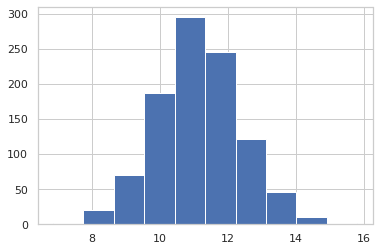

In [360]:
 plt.hist(log_odds[21,:])

In [361]:
post = test_nomissing.posterior_given_XandT(train_data.iloc[0:100,:], T[0:100])
imputed = np.mean(post,1)

postX = test_nomissing.posterior_given_X(train_data.iloc[0:100,:])
imputedX = np.mean(postX,1)

[3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928
 3.38052928 3.38052928 3.38052928 3.38052928 3.38052928 3.3805

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:467: RuntimeWarning: covariance is not positive-semidefinite.


rapid_1-5 days 1 1 0 [0.00314359]
rapid_6-10 days 0 0 0 []
rapid_11-15 days 0 0 0 []
rapid_16-20 days 0 0 0 []
rapid_21+ days 0 0 0 []
rapid_asymptomatic 0 0 0 []
rapid_undefined 1 1 0 [0.00752877]
pcr_1 0 0 0 []
pcr_2 5 5 0 [0.00705075 0.00418417 0.00548119 0.00567688 0.00012506]
pcr_3 14 14 0 [1.87973252e-03 5.83890399e-03 6.65810148e-04 1.61477532e-03
 1.65244595e-03 2.96253190e-03 6.10287424e-03 2.70335381e-03
 6.35746036e-03 7.39532427e-03 6.61944229e-03 9.96010531e-01
 6.15371428e-04 9.92359211e-01]
pcr_4 7 7 0 [0.00128074 0.99680561 0.99371029 0.00481208 0.0057807  0.00783454
 0.00486897]
pcr_5 11 11 0 [0.00461797 0.00541637 0.00154106 0.00663736 0.00171224 0.00666311
 0.00460546 0.00311519 0.00980572 0.00732645 0.00891053]
pcr_6 0 0 0 []
pcr_7 11 11 0 [9.97574284e-01 9.66687925e-03 4.26887792e-04 5.12462454e-04
 7.39572138e-04 9.95334350e-01 1.44542094e-03 7.24311278e-04
 6.08271276e-03 5.55925859e-03 9.77539881e-03]
pcr_8 0 0 0 []
pcr_9 0 0 0 []
pcr_10 2 2 0 [0.0093501  0.0042

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:467: RuntimeWarning: covariance is not positive-semidefinite.


In [362]:
postX

array([[2.48507088e-06, 1.15701047e-06, 9.66169992e-06, ...,
        5.07768547e-06, 8.54996397e-06, 2.10154295e-06],
       [2.63383193e-06, 3.09155612e-06, 3.48513853e-06, ...,
        5.39560383e-06, 2.52734538e-06, 3.72191223e-06],
       [1.90487935e-06, 2.08431007e-06, 1.91553098e-06, ...,
        1.83593050e-06, 1.73761465e-06, 1.23291079e-06],
       ...,
       [2.93675371e-06, 1.81440336e-06, 2.18007677e-06, ...,
        1.19354425e-06, 2.14021990e-06, 2.10318029e-06],
       [2.58500932e-06, 4.25011208e-06, 2.16988416e-06, ...,
        3.05306766e-06, 4.98657938e-06, 2.93127991e-06],
       [2.22170031e-06, 3.29156605e-06, 3.21666992e-06, ...,
        1.10519773e-05, 7.52569102e-06, 8.28609030e-06]])

(array([742., 114.,  51.,  31.,  30.,  15.,  11.,   4.,   1.,   1.]),
 array([0.00058342, 0.03766913, 0.07475484, 0.11184055, 0.14892626,
        0.18601196, 0.22309767, 0.26018338, 0.29726909, 0.3343548 ,
        0.3714405 ]),
 <a list of 10 Patch objects>)

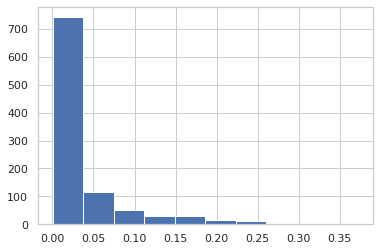

In [364]:
plt.hist(post[21,:])

(array([653., 258.,  59.,  22.,   3.,   3.,   1.,   0.,   0.,   1.]),
 array([9.53831369e-09, 5.88021505e-07, 1.16650470e-06, 1.74498789e-06,
        2.32347108e-06, 2.90195427e-06, 3.48043746e-06, 4.05892065e-06,
        4.63740384e-06, 5.21588703e-06, 5.79437022e-06]),
 <a list of 10 Patch objects>)

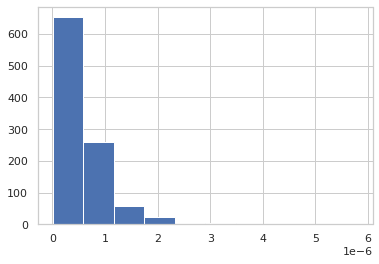

In [341]:
plt.hist(postX[21,:])

In [345]:
np.exp(np.log(1-test_nomissing.params['p_T_0'])  - np.log(test_nomissing.params['p_T_0'])) 

498.9999999999996

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

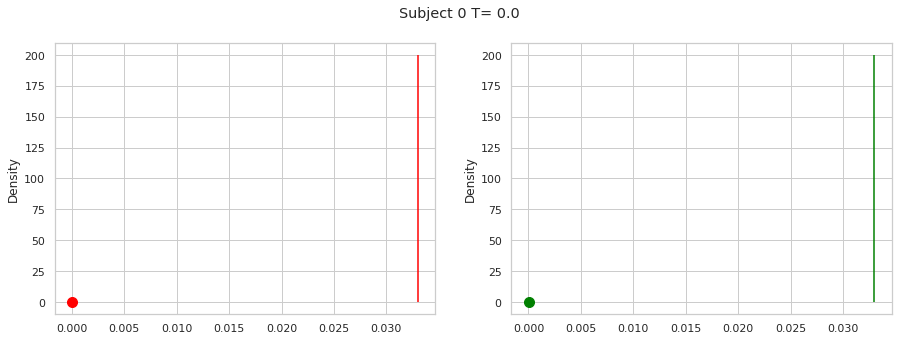

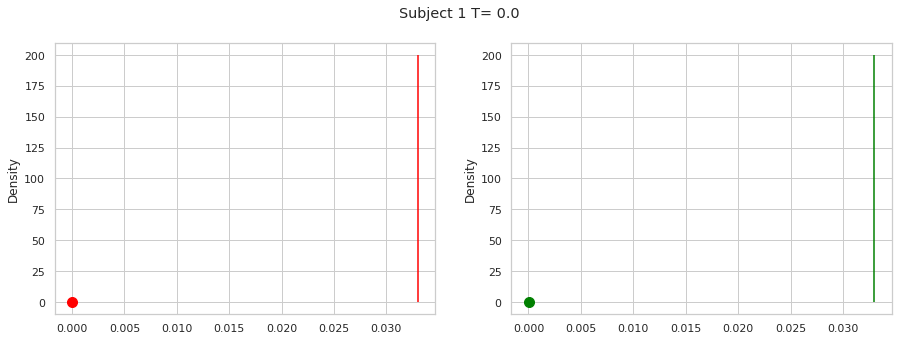

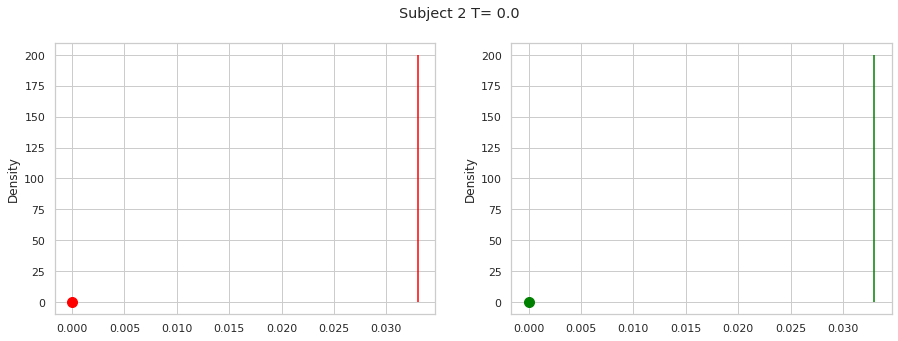

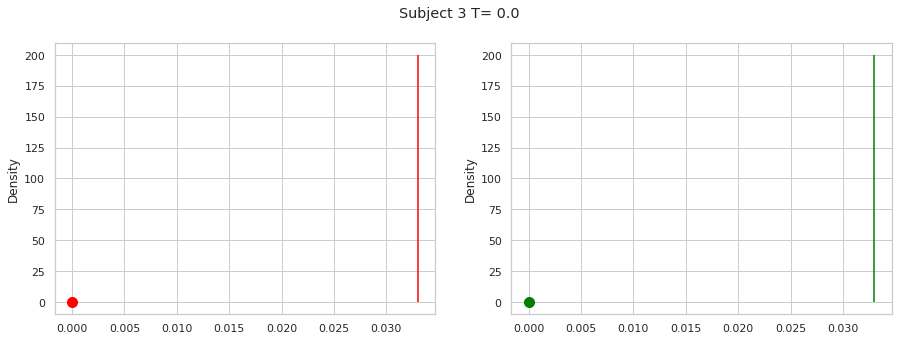

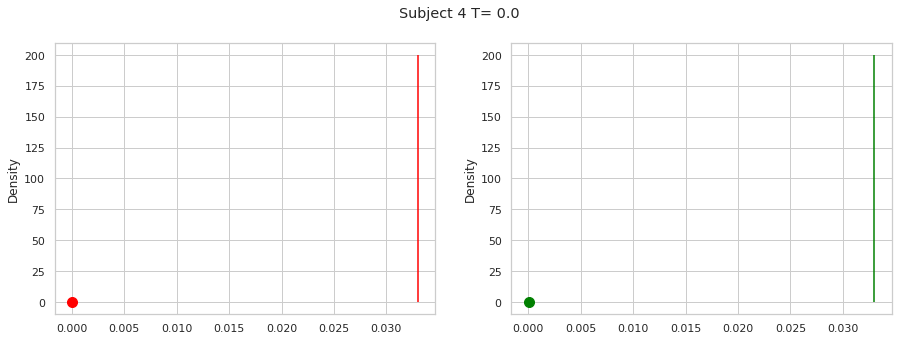

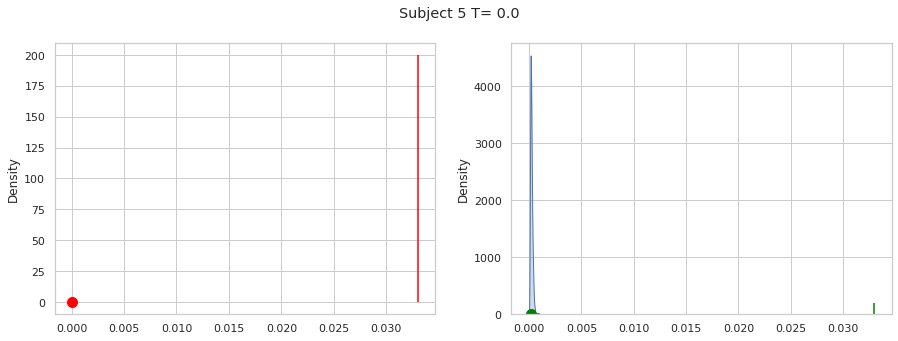

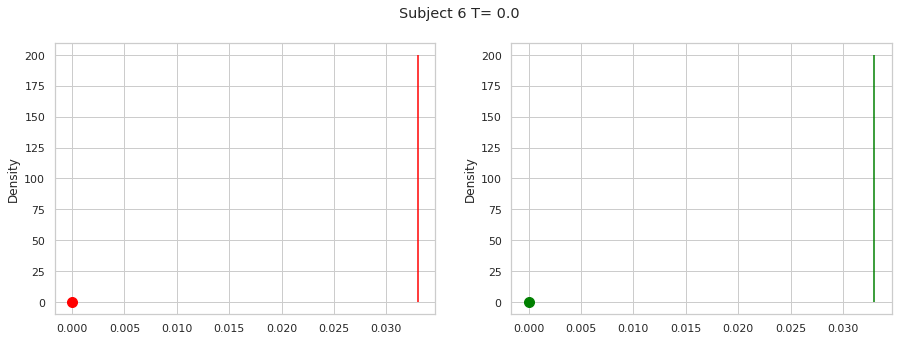

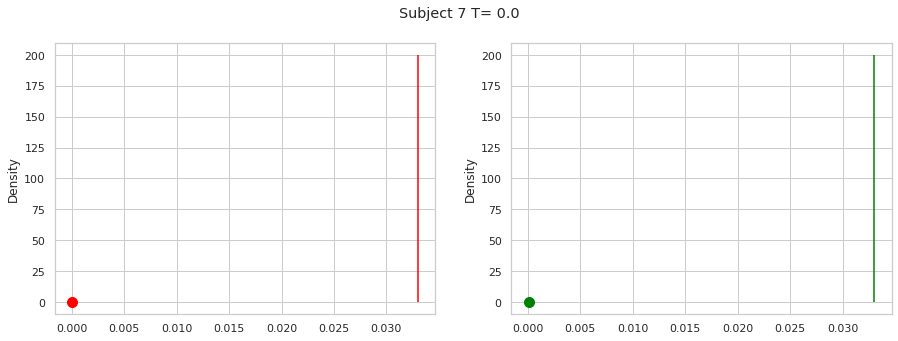

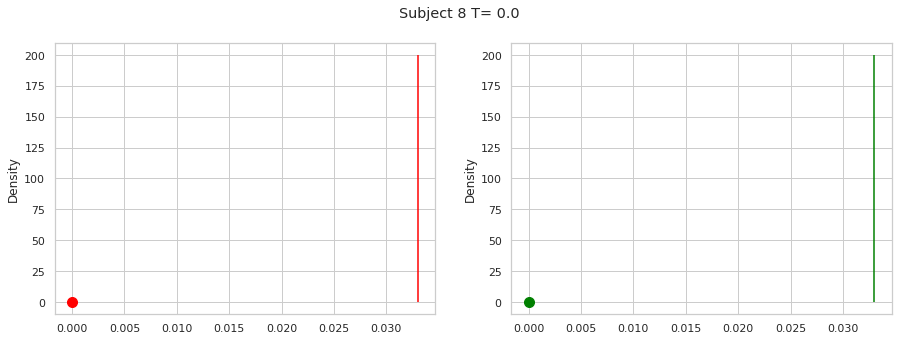

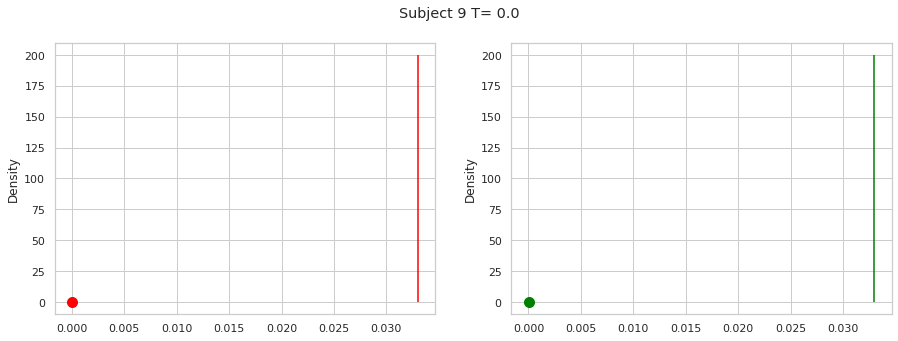

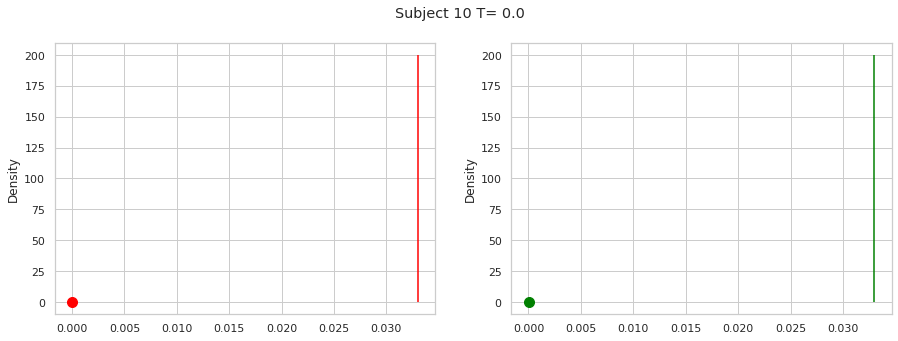

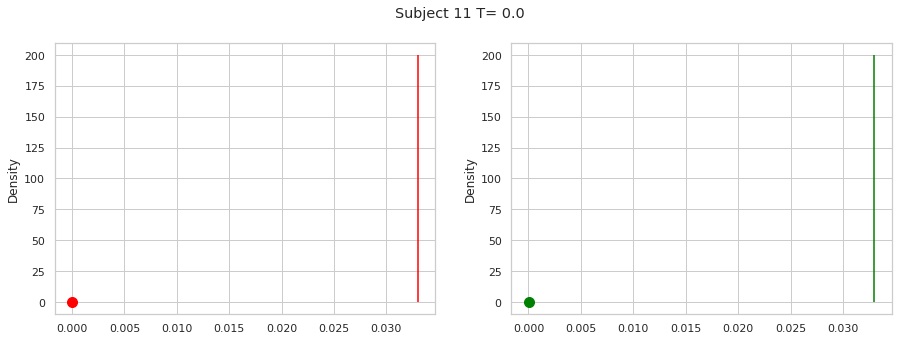

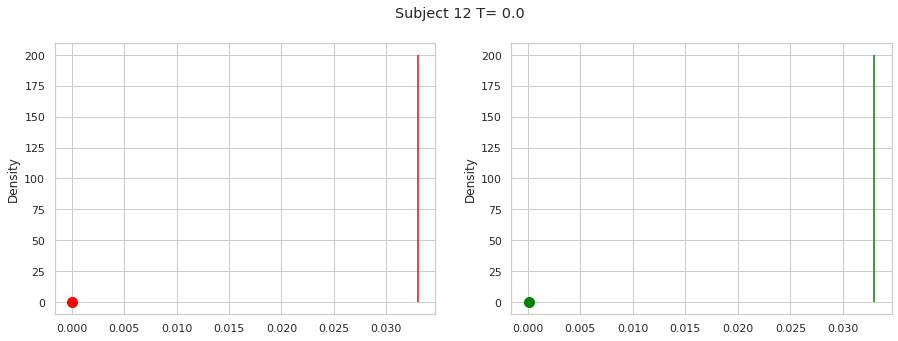

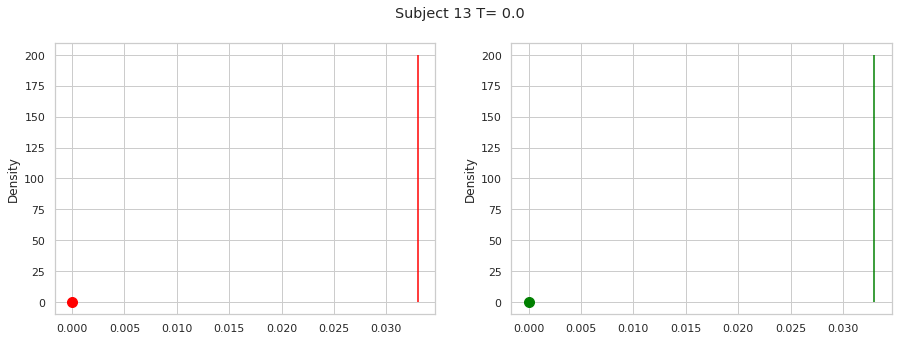

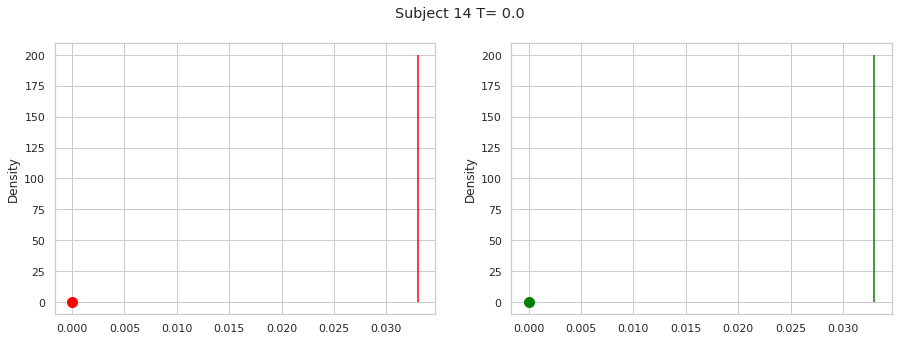

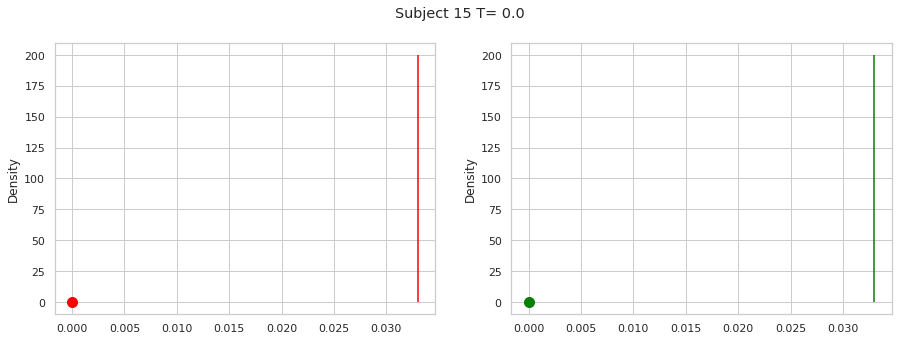

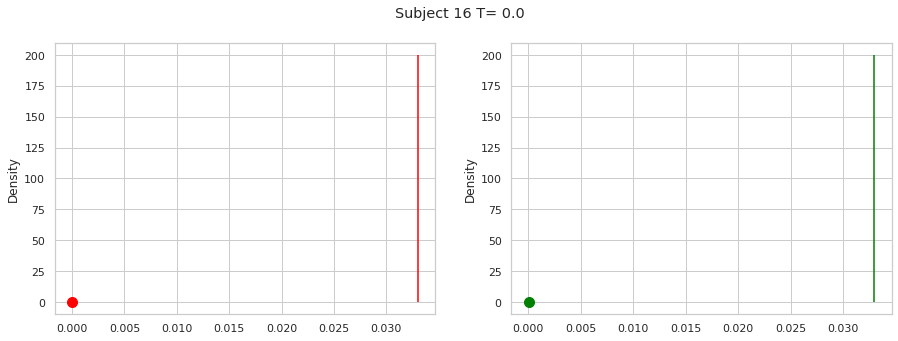

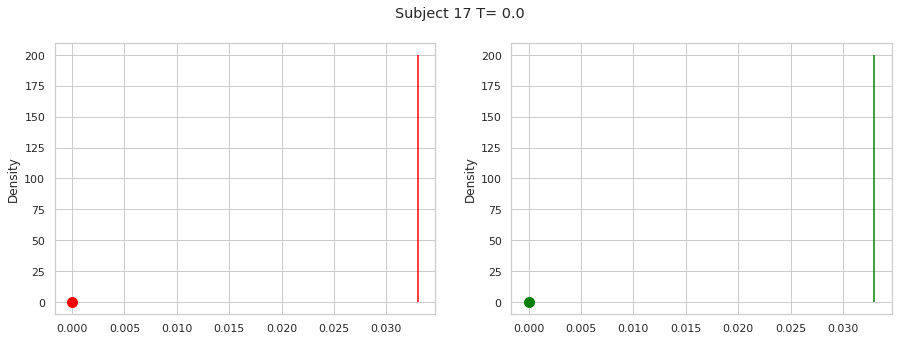

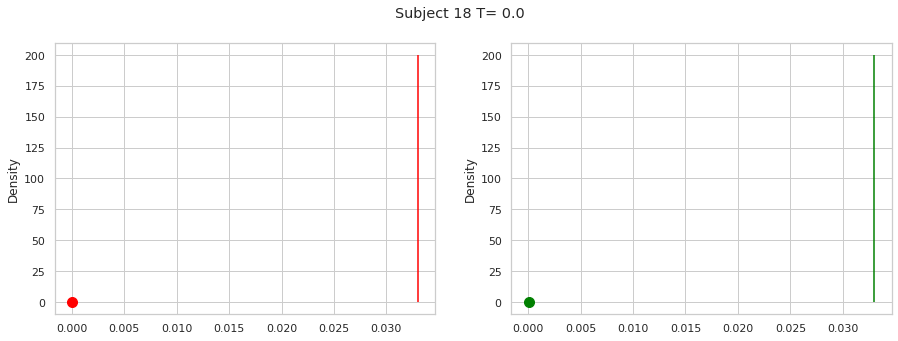

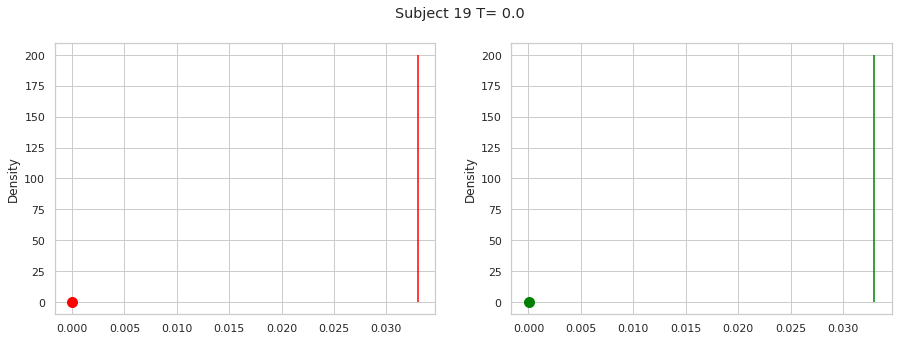

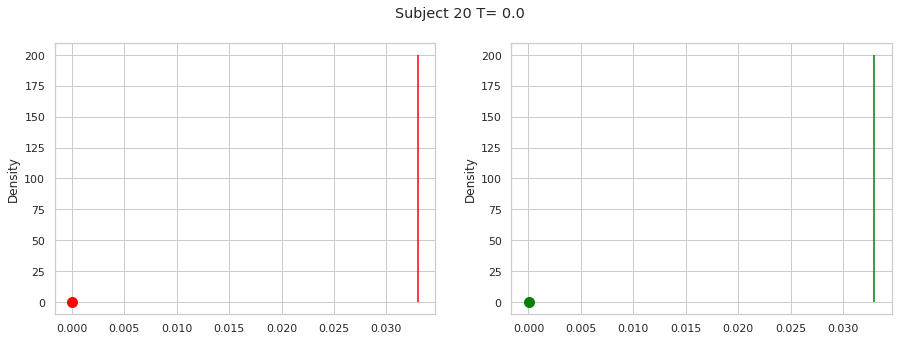

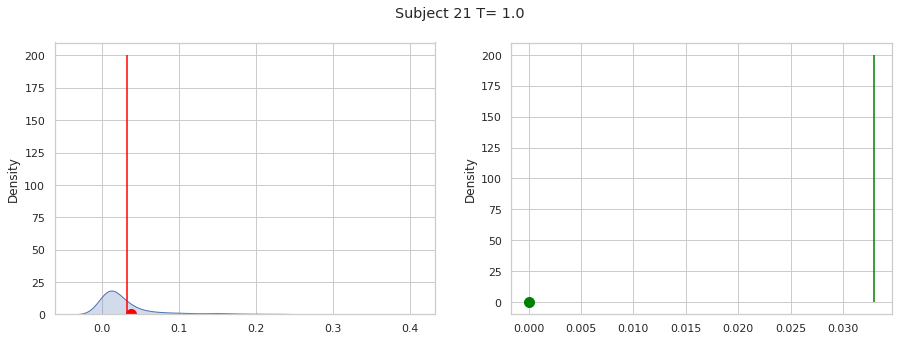

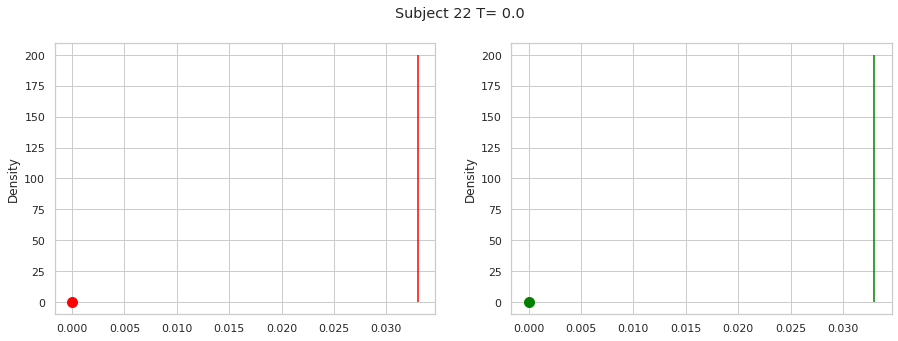

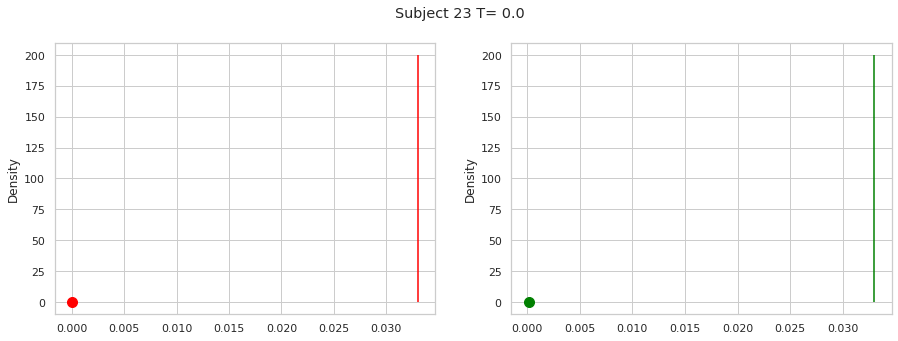

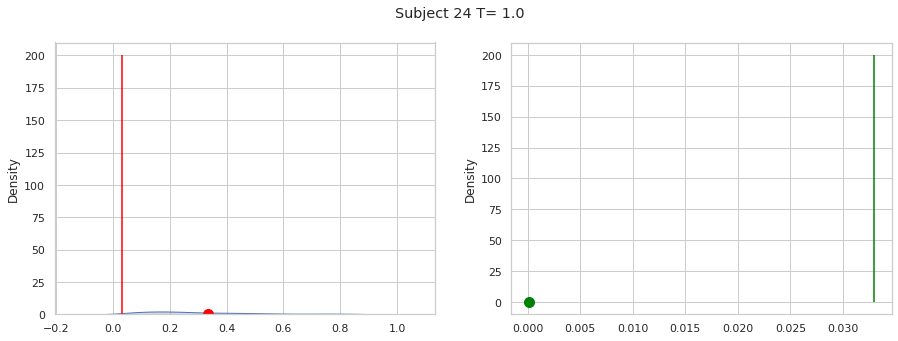

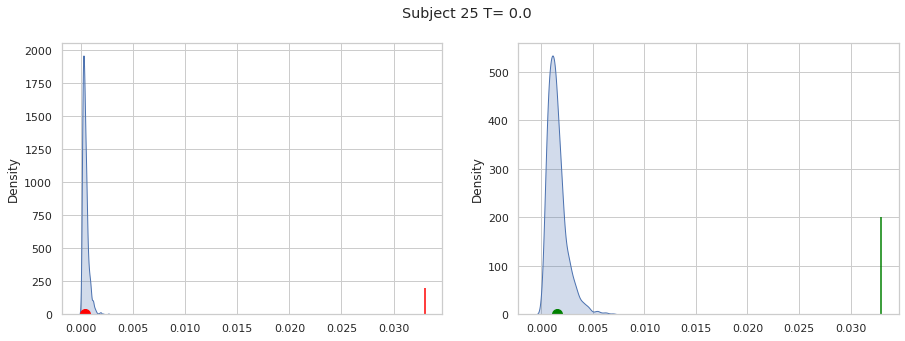

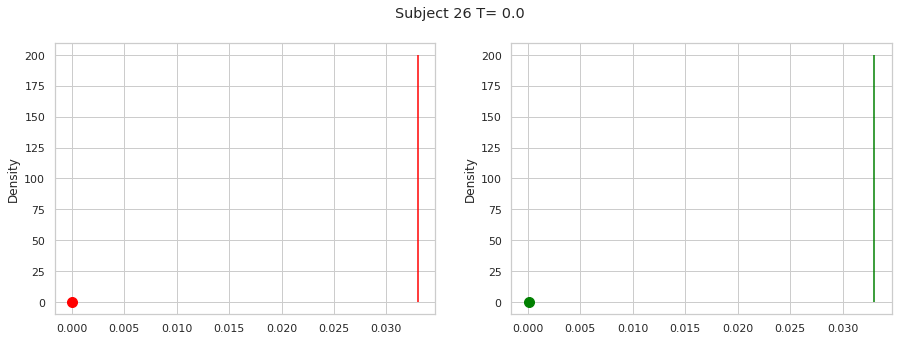

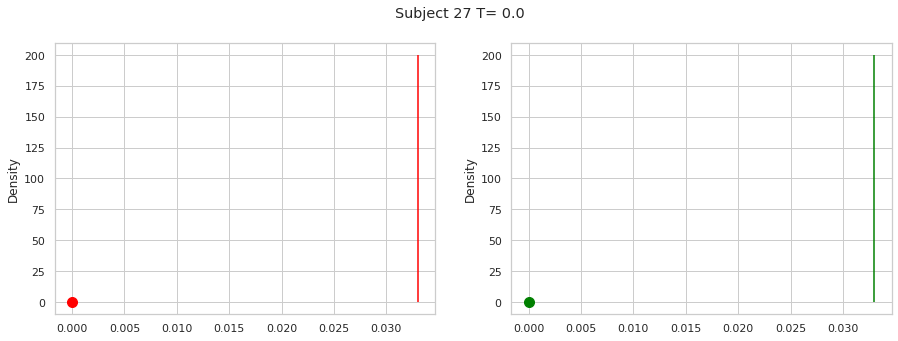

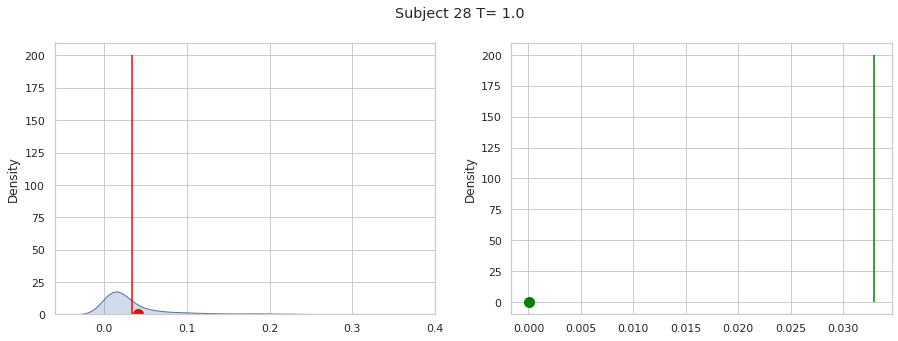

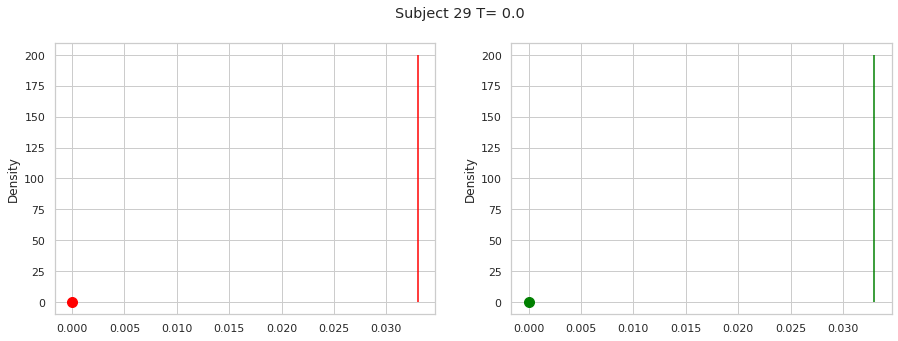

In [365]:
var = 'fever'
kde = True
var_name = var
quant = False
#i = disagreement_nomissing[1]
for i in np.arange(30):
  T_temp = (train_data['results'].iloc[i] == 'Positive') * 1.0
  fig, axes = plt.subplots(1,2, figsize=(15, 5), sharey=False)

  sb.kdeplot(post[i,:], fill=True, ax = axes[0])
  axes[0].scatter(x=[imputed[i]], y =[0.02],c="red", s=100)
  axes[0].vlines(x=[0.033], ymin=0, ymax = 200,color="red")
  fig.suptitle("Subject "  + str(i) + " T= " + str(T_temp))
  #plt.savefig('/content/drive/My Drive/subject' + str(i) + '.pdf')

  sb.kdeplot(postX[i,:], fill=True, ax = axes[1])
  axes[1].scatter(x=[imputedX[i]], y =[0.02],c="green", s=100)
  axes[1].vlines(x=[0.033], ymin=0, ymax = 200,color="green")
  #plt.title("T= " + str(T_temp))
  #plt.tight_layout()
  #plt.savefig('/content/drive/My Drive/subjectX' + str(i) + '.pdf')

In [ ]:
imputed

In [232]:
train_data.iloc[18][SYMPTOMS + list(SYMPTOMS_QUANT.keys()) + CONTEXT_INFO + ['results']]

ctab                                False
labored_respiration                  True
rhonchi                             False
wheezes                             False
cough                                True
fever                               False
sob                                  True
diarrhea                            False
fatigue                             False
headache                            False
loss_of_smell                       False
loss_of_taste                       False
runny_nose                          False
muscle_sore                         False
sore_throat                         False
cough_severity                          2
fever_severity                          0
howShortOfBreath                        3
high_risk_exposure_occupation       False
high_risk_interactions                  0
results                          Negative
Name: 18, dtype: object

In [239]:
test_nomissing.hyperparams['p_symptomatic_0']

0.0003882999135724603

In [238]:
test_nomissing.params['p_symptomatic_1']

0.8491549150741324

In [ ]:
data['prevalence'].iloc[33]

In [ ]:
SPECIFICITY_PRIORS

# IV. Bayesian Meta-analysis

In [ ]:
symptoms = pd.read_csv("/content/drive/My Drive/C3AI_code/symptoms_metaanalysis.csv")

In [ ]:
alpha=0.5
beta=0.5
symptoms_p = symptoms.apply(lambda x: np.random.beta(alpha + x.fever, beta + x.n -x.fever), axis=1)

In [ ]:
lor = np.log(symptoms_p/(1-symptoms_p))

In [ ]:
plt.hist(lor)

In [ ]:
mean_x = np.mean(x)
ss = np.sum(np.square(x - mean_x))
mu_n = (nu * mu0 + n * mean_x)/(nu + n) 
nu_n = nu  + n
alpha_n = alpha + n/2
beta_n = beta + 0.5 * ss + n *nu/(nu + n) * (mean_x - mu0)**2/2
s2 = np.random.

In [ ]:
### update_posteriors
from sklearn.linear_model import LogisticRegression, LinearRegression
class EMClassifier3:
    ''' Parent class for EM variations
    Variations will have to instantiate the quantitative symptom functions
    and potentially overwrite the ones for the symptoms if doing SEM
    Parameters
    ----------
    method_missing_T : str, {'truncated', 'latent-DT', 'latent-DT-newprior'}
        Method chosen to imput the missing T:
        - 'truncated': cf Section "StEM with missing T: truncated Bayesian network"
            * E-step: Imput Di
                - When T non-missing: using the full Bayesian network
                - When T missing: using the truncated Bayesian network without the T branch
            * M-step:
                - Update p of symptomatic/symptoms/betas as before, with imputed Dis
                - Update sensitivity/specificity by summing only on i's with non-missing T
        - 'latent-DT': cf Section "StEM with missing T: missing and hidden variables"
            * E-step: Imput Di, Ti
                - When T non-missing: as usual with the full Bayesian network
                - When T missing: using the joint posterior p(D, T| observations)
            * M-step: Update parameters using imputed Di and Ti
        - 'latent-DT-newprior': cf Section "StEM with missing T: missing and hidden variables" (Enhancement)
            * Same as 'latent-DT' but using a different prior on sensitivity/specificity 
            when T is missing.
    '''
    def __init__(self, list_symptoms=SYMPTOMS,
                 list_symptoms_quant=SYMPTOMS_QUANT,
                 list_context_variables=CONTEXT_INFO,
                 params_dist=None,
                 hyperparams_dist=None, EM_steps=20, B=1000, beta=None,
                 specificity_priors=SPECIFICITY_PRIORS,
                 sensitivity_priors=SENSITIVITY_PRIORS,
                 separate_asymptomatic=False,
                 update_sensitivity=False,
                 update_symptomatic=False,
                 update_prior_symptoms=True,
                 completely_agnostic_prior=False,
                 convergence_threshold=1e-3,
                 params_names_quant=['a', 'b'],
                 use_prevalence = True,
                 use_prevalence_ili = False,
                 stochastic = False,
                 method_missing_T='latent-DT'):
        self.model = None
        self.EM_steps = EM_steps  ## nb of EM steps to take
        self.separate_asymptomatic = separate_asymptomatic ### are we taking into account a symptomatic variable? Or should this be fixed?
        self.update_sensitivity = update_sensitivity ### are we updating the sensitivity of the tests?
        self.update_symptomatic = update_symptomatic
        self.use_prevalence = use_prevalence
        self.use_prevalence_ili = use_prevalence_ili
        self.B = B             
        self.list_context_variables = list_context_variables
        self.list_symptoms = list_symptoms
        self.list_symptoms_quant = list_symptoms_quant.keys()
        self.specificity = specificity_priors
        self.sensitivity = sensitivity_priors
        self.stochastic = stochastic
        self.method_missing_T = method_missing_T
        self.convergence = 0
        self.convergence_threshold = convergence_threshold
        self.completely_agnostic_prior=completely_agnostic_prior
        self.update_prior_symptoms = update_prior_symptoms
        self.params_names_quant =  params_names_quant  ### names of the parameters for the quant distributions --allows  extra flexibility
        self.H = np.diagflat(np.zeros((len(list_context_variables)+1)))
        if beta is None:
            self.beta_reg = np.zeros(len(self.list_context_variables)) ##coef for the context log reg
        else:
            self.beta_reg = np.zeros(len(self.list_context_variables))
        ##### Initialize all the parameters in the Bayesian Model
        list_params_names = [a + 'T_' + k + e for a in ['alpha_', 'beta_', 'p_']
                            for e in ['_0','_1'] for k in self.specificity.keys()]  ### tests
        list_params_names += [a  +  n + '_' + e for a in ['alpha_', 'beta_', 'p_']
                            for e in ['0','1'] for n in self.list_symptoms + ['symptomatic']] ### symptoms
        self.hyperparams = {k: 1.2 for k in list_params_names}
        self.hyperparams.update({'mu_beta': np.zeros(len(CONTEXT_INFO)),
                                 'lambda_beta': 10,
                                 'Sigma_beta': np.diag(np.ones(len(CONTEXT_INFO))),
                                 'psi_beta': np.diag(np.ones(len(CONTEXT_INFO))),
                                 'nu_beta': 10}) ###  regression
        self.hyperparams.update({ a + '_' + n + '_' + e: np.ones(list_symptoms_quant[n][0])
                            for n in self.list_symptoms_quant 
                            for a in list_symptoms_quant[n][1] 
                            for e in ['0','1']})
        self.params = {k: 0.5 for k in list_params_names}  ## simple declaration
        self.params.update({'mu_beta': np.zeros(len(CONTEXT_INFO)),
                            'lambda_beta': 10,
                            'psi_beta': np.diag(np.ones(len(CONTEXT_INFO))),
                            'Sigma_beta': np.diag(np.ones(len(CONTEXT_INFO))),
                            'nu_beta': 10}) ###  regression
        self.params.update({a + '_' + k + '_' + e: 0.5* np.ones(list_symptoms_quant[k][0])
                            for k in list_symptoms_quant.keys()
                            for e in ['0', '1'] for a in list_symptoms_quant[k][1]})
        for k in self.specificity.keys():
            self.hyperparams['alpha_T_' + k + '_1'] = self.sensitivity[k][0]
            self.hyperparams['beta_T_' + k +  '_1'] = self.sensitivity[k][1]
            self.hyperparams['alpha_T_' + k +  '_0'] = self.specificity[k][0]
            self.hyperparams['beta_T_'  + k +  '_0'] = self.specificity[k][1]
            self.params['alpha_T_' + k + '_1'] = self.sensitivity[k][0]
            self.params['beta_T_' + k +  '_1'] = self.sensitivity[k][1]
            self.params['alpha_T_' + k +  '_0'] = self.specificity[k][0]
            self.params['beta_T_'  + k +  '_0'] = self.specificity[k][1]

        ##### Option to pass different more informative initial values1
        if hyperparams_dist is not None:
        	for k in hyperparams_dist.keys(): self.hyperparams[k] = hyperparams_dist[k]
        if params_dist is not None:
        	for k in params_dist.keys(): self.params[k] = params_dist[k]
    
    def update_logs_bernouilli(self, X, n):
      '''' Updates the log likelihood for observations X (dim N),
      with the params of the model
      '''
      res = (X) * np.log(self.params['p_' + n +'_0']) \
            + (1. - X) * np.log(1-self.params['p_' + n +'_0'])\
            - (X) * np.log(self.params['p_' + n +'_1'])\
            - (1. - X) * np.log(1-self.params['p_' + n +'_1'])
    
      if self.method_missing_T == 'truncated':
          # This takes into account the case 
          # where T is missing, i.e. T=NaN in the df.
          # in the truncated Bayesian model
          res[np.isnan(X)] = 0
      return res

    def update_logs_multinomial(self, X, n):
        res0 = np.array(list(map(lambda x: np.log(self.params['pi_'+ n + '_0' ][int(x)]), X)))
        res1 = np.array(list(map(lambda x: np.log(self.params['pi_'+ n + '_1' ][int(x)]), X)))
        return res0 - res1
    
    def update_logs_samplebernouilli(self, X, sample):
      ''' Updates the log likelihood for observations X (dim N),
      with samples proba sample (N x B)
      '''
      res = (np.einsum('i, ij -> ij', X, np.log(sample)) \
            + np.einsum('i, ij -> ij', 1-X, np.log(1 - sample)))
      return res
    
    def add_updates2beta_prior(self, imputed_labels, X):
      ''' Computes the updates to add to the beta hyperparams
      '''
      # X may be NaN, for example if X=T
      add_one_alpha = np.multiply(imputed_labels, X)
      if self.method_missing_T == 'truncated':
          add_one_alpha = np.nan_to_num(add_one_alpha, nan=0.)

      add_one_beta = np.multiply(imputed_labels, 1-X)
      if self.method_missing_T == 'truncated':
          add_one_beta = np.nan_to_num(add_one_beta, nan=0.)

      # This only sums over the non-NaN values
      add_alpha = np.sum(add_one_alpha)
      add_beta = np.sum(add_one_beta)
      return add_alpha, add_beta
    
    def update_logs_beta(self, X, n):
      ''' Updates log likelihood for X if X is beta
      '''
      B1 = sc.special.beta(self.params['alpha_' + n +'_1'],
                          self.params['beta_' + n +'_1'])
      B0 = sc.special.beta(self.params['alpha_' + n +'_0'],
                          self.params['beta_' + n +'_0'])
      res = (self.params['alpha_' + n +'_0']-1) * np.log(X)+\
            (self.params['beta_' + n +'_0']-1) * np.log(1-X)+\
          -(self.params['alpha_' + n +'_1']-1) * np.log(X)+\
          -(self.params['beta_' + n +'_1']-1) * np.log(1-X)+\
          np.ones((len(index_sympt))) * (np.log(B1) - np.log(B0))
      return res

    def update_dirichlet(self, X, imputed_labels, n):
        added1 = [np.sum(np.multiply((X == k), imputed_labels))
                 for k in np.arange(self.params['alpha_dir_'+ n].shape[0])]
        self.params['pi_'+ n] = (self.hyperparams['alpha_dir_'+ n] + added1)/ np.sum(self.hyperparams['alpha_dir_'+ n] + added1)
        self.params['alpha_dir_'+ n] = (self.hyperparams['alpha_dir_'+ n] + added1)
                
    
    def update_bernouilli(self, n):
      ''' Updates params for X if X is bernouilli
      '''
      if (self.params['alpha_'+ n]> 1 and self.params['beta_'+ n]>1):
        res = ((self.params['alpha_'+ n] -1)/
              (self.params['alpha_'+ n]+ self.params['beta_'+ n] - 2))
      else:
        res = ((self.params['alpha_'+ n] )/
              (self.params['alpha_'+ n]+ self.params['beta_'+ n]))
      self.params['p_' + n]  = res
    
    def update_beta(self, n, add_alpha, add_beta):
      ''' Updates params for X if X is beta
      '''
      self.params['alpha_'+ n] = add_alpha + self.hyperparams['alpha_'+ n] 
      self.params['beta_'+ n] = add_beta + self.hyperparams['beta_'+ n]

    def update_mvn_known_Sig(self, n, X, Y):
      ''' Updates params for n if n is a multivariate normal distribution
      (ie, the regression coefficients for instance, assuming known covariance)
      '''
      #print("mvn start, nb of Y nan",np.sum(np.isnan(Y)))
      x = X[self.list_context_variables].values.astype(float)
      self.params['Sigma_'+ n] = self.hyperparams['Sigma_'+ n]  + x.T.dot(x)
      #print(x.T.dot(x))
      #print(self.params['Sigma_'+ n])
      #Om = np.linalg.inv(self.params['Sigma_'+ n])
      #print("inverse", np.linalg.inv(self.params['Sigma_'+ n]))
      self.params['mu_'+ n] = np.linalg.inv(self.params['Sigma_'+ n]).dot(self.hyperparams['mu_'+ n]  + x.T.dot(Y)) 
      #print("mu", self.params['mu_'+ n], self.hyperparams['mu_'+ n] , x.T.dot(Y))
      self.beta_reg = self.params['mu_'+ n] 

    def update_mvn(self, n, temp_lab, X):
      ''' Updates params for n if n is a multivariate normal distribution
      (ie, the regression coefficients for instance)
      '''
      n = X.shape[0]
      #mean_data = np.mean(x, axis=0)
      sum_squares = np.sum([np.array(np.matrix(xx - mean_data).T * np.matrix(xx - mean_data)) for xx in x], axis=0)
      self.params['mu_'+ n] = (self.params['lambda_'+ n] * self.hyperparams['lambda_'+ n] + n * mean_data) / (self.params['lambda_'+ n]  + n)
      self.params['lambda_'+ n] = self.hyperparams['lambda_'+ n] + n
      self.params['nu_'+ n] = self.hyperparams['nu_'+ n]  + n
      self.params['psi_'+ n] = self.hyperparams['psi_'+ n]  + sum_squares + \
      self.hyperparams['lambda_'+ n]  * n / float( self.hyperparams['lambda_'+ n]  + n) *\
       np.array(np.matrix(mean_data - self.hyperparams['mu_'+ n]).T *\
                np.matrix(mean_data - self.hyperparams['mu_'+ n]))
    
    def update_normal_with_meta_analyses(self, n, temp_lab, X):
      ''' Updates params for n if n is a normal distribution
      (ie, the regression coefficients for instance)
      '''
      x = np.multiply(temp_lab * X[n].values)
      x = np.log(np.sum(x)/(np.sum(temp_lab) - np.sum(x)))
      #x = meta_analyses[n].values + [lor]
      #mean_data = np.mean(x, axis=0)
      #mean_x = np.mean(x)
      #ss = np.sum(np.square(x - mean_x))
      self.params['mu_'+ n] = (self.hyperparams['nu_'+ n]  * self.hyperparams['mu_'+ n]+ x )/(self.hyperparams['nu_'+ n]  + 1) 
      self.params['nu_'+ n]  = self.hyperparams['nu_'+ n]  + 1
      self.params['alpha_'+ n]  = self.hyperparams['alpha_'+ n]  + 0.5
      self.params['beta_'+ n] = self.hyperparams['beta_'+ n]  +\
       self.hyperparams['nu_'+ n]/(self.hyperparams['nu_'+ n] + 1) * (x - self.hyperparams['mu_'+ n])**2/2

    def sample_normal_with_meta_analyses(self, n, temp_lab, X):
      ''' Updates params for n if n is a normal distribution
      (ie, the regression coefficients for instance)
      '''
      inv_s2 = np.random.gamma(self.params['alpha_'+ n], self.params['beta_'+ n])
      return np.random.normal(self.params['mu_'+ n], np.sqrt(1.0/(self.params['nu_'+ n] * inv_s2))
      

    
    def update_beta_prob_momentmatch(self, temp_lab, X, n):
      ''' Updates params for X if X is beta by moment matching
      '''
      xbar = np.sum(np.multiply(temp_lab , X)) / np.sum(temp_lab)
      s2 = np.sum(np.multiply(temp_lab , (X -xbar)**2)) / np.sum(temp_lab)
      a = xbar * (xbar * (1. - xbar) / s2 - 1.0)
      self.params['alpha_'+ n] = a
      self.params['beta_'+ n] =  a * (1. - xbar) / xbar
    
    def update_logs_quant(self, X, n):
      self.update_logs_multinomial(X, n)
      return None
    
    def update_quant_prior(self, X, imputed_labels, n):
      self.update_dirichlet(X, imputed_labels, n)
        
    def update_logs_prior(self, X, n):
        return self.update_logs_multinomial(X, n)
        
    def sample_quant(self, n, size):
        sample = np.random.dirichlet(self.params['alpha_dir_'+ n], size * self.B)
        samples = np.reshape(sample, ((size, self.B, sample.shape[1])))
        return samples

    def update_logs_samplequant(self, X, samples):
      enc = np.zeros((X.size, samples.shape[2]))
      enc[np.arange(X.size),X.astype('int')] = 1
      vlog = np.vectorize(lambda x: np.log(x) if x>1e-7 else np.log(1e-7))
      res = np.einsum('ik, ijk -> ij', enc, vlog(samples)) 
      return res
   
    def expectation(self, data, T):
        """ Computes the expectation of the hidden variables given
        the different parameters. The hidden variables in our model are D and self.x, self.y
        INPUTS
        ---------------------------------------------------------------------
        Y                   :       context + questionnaire data
        T                   :       image classification label (binary)
        D                   :       imputed diagnostic
        """
        #### MLE
        N = data.shape[0]
        index_sympt = np.arange(data.shape[0])
        log_odds = np.zeros(N)
        if self.use_prevalence:
            log_odds_prev = np.log(data['prevalence'].values)- np.log(1.0 - data['prevalence'].values )
            log_odds += - log_odds_prev
        elif self.use_prevalence_ili:
              log_odds_prev = np.multiply(data['symptomatic'].values, 
                                        np.log(data['p01'].values)- np.log(1.0 - data['p11'].values )
                            ) + np.multiply(1.0 - data['symptomatic'].values, 
                                        np.log(data['p00'].values)- np.log(1.0 - data['p10'].values )
                            )
              log_odds += log_odds_prev
        else:
            ### Now add the prior with context info
            self.beta_reg = self.params['mu_beta']
            #Y = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
            #              data[self.list_context_variables]])
            Y = data[self.list_context_variables].values.astype('float')
            log_odds = - np.log(data['prevalence'].values) +  np.log(1.0 - data['prevalence'].values ) 
            print('log odds before regression', log_odds) 
            print("beta", self.beta_reg)
            log_odds += - Y.dot(self.beta_reg) # - log_odds_prev
            print('log odds after regression', log_odds)
            #print('log odds after regression', log_odds)

        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
            ### Start by updating the symptomatic columns
            if self.use_prevalence_ili == False:
                X  = data['symptomatic'].values
                log_odds += self.update_logs_bernouilli(X, 'symptomatic')

            
        for k in self.specificity.keys():
              index = np.where(data['label_t']==k)
              log_odds[index] += self.update_logs_bernouilli(T[index], 'T_' + k)
        for n in self.list_symptoms:
            X  = data[n].iloc[index_sympt].values
            log_odds[index_sympt] += self.update_logs_bernouilli(X, n) 
            #print('log odds',n, log_odds)
        for n in self.list_symptoms_quant:
            #### We sample a bunch as we parametrize it by beta dist
            X  = data[n].iloc[index_sympt].fillna(0).values
            log_odds[index_sympt] += self.update_logs_prior(X, n)

        imputed_labels = np.divide(np.ones(N),
                         np.ones(N) + np.exp(log_odds))
        if self.stochastic:
            imputed_labels = np.random.binomial(n=1, p=imputed_labels)
        return imputed_labels

    def _impute_D_and_T_from_post(
            self, p_D0_T0, p_D0_T1, p_D1_T0, p_D1_T1):

        N = len(p_D0_T0)
        imputed_labels = np.zeros(N)
        imputed_T = np.zeros(N)

        for i in range(N):
            p_D0_T0_i, p_D0_T1_i = p_D0_T0[i], p_D0_T1[i]
            p_D1_T0_i, p_D1_T1_i = p_D1_T0[i], p_D1_T1[i]
            imputed_category = np.random.multinomial(
                n=1, pvals=[p_D0_T0_i, p_D0_T1_i, p_D1_T0_i, p_D1_T1_i])
            if imputed_category[0] == 1:
                imputed_labels[i] = 0  
                imputed_T[i] = 0    
            elif imputed_category[1] == 1:
                imputed_labels[i] = 0  
                imputed_T[i] = 1 
            elif imputed_category[2] == 1:
                imputed_labels[i] = 1  
                imputed_T[i] = 0 
            elif imputed_category[3] == 1:
                imputed_labels[i] = 1  
                imputed_T[i] = 1 
        return imputed_labels, imputed_T

    def expectation_with_missing_T(self, data):
        """ Computes the expectation of the hidden variables D, T given
        the different parameters.
        The parameter data is the subset of the data that have missing T.
        """
        #### MLE
        N = data.shape[0]
        Y = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
                       data[self.list_context_variables]])
        log_p_D0_T0 = np.zeros(N)
        log_p_D1_T0 = np.zeros(N)

        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
            ### Start by updating the symptomatic columns
            S  = data['symptomatic'].values
            p0 = self.params['p_symptomatic_0']
            p1 = self.params['p_symptomatic_1']
            log_p_D0_T0 += S * np.log(p0) + (1 - S) * np.log(1-p0)
            log_p_D1_T0 += S * np.log(p1) + (1 - S) * np.log(1-p1)
        else:
            index_sympt = np.arange(data.shape[0])

        for n in self.list_symptoms:
            ### Update the symptomatic for the ones that got sick
            X  = data[n].iloc[index_sympt].values
            #print("here missing T", n)
            p0 = self.params['p_' + n + '_0']
            p1 = self.params['p_' + n + '_1']

            log_p_D0_T0[index_sympt] += X * np.log(p0) + (1 - X) * np.log(1-p0)
            log_p_D1_T0[index_sympt] += X * np.log(p1) + (1 - X) * np.log(1-p1)

        for n in self.list_symptoms_quant:
            #### We sample a bunch as we parametrize it by beta dist
            #print("here ", n )
            X  = data[n].iloc[index_sympt].fillna(0).values

            pi0 = self.params['pi_'+ n + '_0']
            pi1 = self.params['pi_'+ n + '_1' ]

            log_p_D0_T0[index_sympt] += np.array(list(map(lambda x: np.log(pi0[int(x)]), X)))
            log_p_D1_T0[index_sympt] += np.array(list(map(lambda x: np.log(pi1[int(x)]), X)))

        ### Now add the prior with context info
        log_p_D0_T0 += - Y.dot(self.beta_reg) - np.log(
            1 + np.exp(- Y.dot(self.beta_reg)))
        log_p_D1_T0 += - np.log(1 + np.exp(- Y.dot(self.beta_reg)))

        log_p_D0_T1 = copy.deepcopy(log_p_D0_T0)
        log_p_D1_T1 = copy.deepcopy(log_p_D1_T0)

        # Now add the logs that are specific to each of the 4 probas
        for k in self.specificity.keys():
            index = np.where(data['label_t']==k)
            p_T_0 = self.params['p_T_' + k + '_0']
            p_T_1 = self.params['p_T_' + k + '_1']

            log_p_D0_T0[index] += np.log(1 - p_T_0)
            log_p_D0_T1[index] += np.log(p_T_0)
            log_p_D1_T0[index] += np.log(1 - p_T_1)
            log_p_D1_T1[index] += np.log(p_T_1)   

        p_D0_T0 = np.exp(log_p_D0_T0)
        p_D0_T1 = np.exp(log_p_D0_T1)
        p_D1_T0 = np.exp(log_p_D1_T0)
        p_D1_T1 = np.exp(log_p_D1_T1)
        p_sum = p_D0_T0 + p_D0_T1 + p_D1_T0 + p_D1_T1
        p_D0_T0 /= p_sum
        p_D0_T1 /= p_sum
        p_D1_T0 /= p_sum
        p_D1_T1 /= p_sum

        imputed_labels, imputed_T = self._impute_D_and_T_from_post(
             p_D0_T0, p_D0_T1, p_D1_T0, p_D1_T1)
        return imputed_labels, imputed_T

    def maximization(self, data, T, imputed_labels, agnostic_init=False):
        ''' Maximization of the parameters for the model, that is the $beta$ and coefficients
        for the symptoms
        '''
        N,_ = data.shape
        lab_t = data['label_t']
        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
            X = data['symptomatic'].values
            if self.update_symptomatic:
                add_alpha1, add_beta1 = self.add_updates2beta_prior(imputed_labels, X)
                add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - imputed_labels, X)
                self.update_bernouilli('symptomatic_1')
                self.update_bernouilli('symptomatic_0')

            if (self.update_prior_symptoms) or (not agnostic_init):
              self.update_beta('symptomatic_1', add_alpha1, add_beta1)
              self.update_beta('symptomatic_0', add_alpha0, add_beta0)
                
        else:
            index_sympt = np.arange(data.shape[0])
            
        for k in self.specificity.keys():
            index = np.where(lab_t == k)[0]
            if self.update_sensitivity:
              add_alpha1, add_beta1 = self.add_updates2beta_prior(imputed_labels[index], T[index])
              add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - imputed_labels[index], T[index])
              self.update_beta('T_' + k + '_1', add_alpha1, add_beta1)
              self.update_beta('T_' + k + '_0', add_alpha0, add_beta0)
            self.update_bernouilli('T_' + k  + '_1')
            self.update_bernouilli('T_' + k + '_0')
        for n in self.list_symptoms:
            X = data[n].iloc[index_sympt].values
            temp_lab =  imputed_labels[index_sympt]
            add_alpha1, add_beta1 = self.add_updates2beta_prior(temp_lab, X)
            add_alpha0, add_beta0 = self.add_updates2beta_prior(1. - temp_lab, X)
            if (self.update_prior_symptoms) or (not agnostic_init):
              self.update_beta(n + '_1', add_alpha1, add_beta1)
              self.update_beta(n + '_0', add_alpha0, add_beta0)
              self.update_bernouilli(n + '_1')
              self.update_bernouilli(n + '_0')
        for n in self.list_symptoms_quant:
            X = data[n].iloc[index_sympt].values
            temp_lab =  imputed_labels[index_sympt]
            self.update_quant_prior(X, temp_lab, n + '_1')
            self.update_quant_prior(X, 1 - temp_lab, n + '_0')
        
        Y =  - np.log(imputed_labels) + np.log(1.0-imputed_labels)
        #print("pure Y", np.sum(np.isnan(- np.log(imputed_labels) + np.log(1.0-imputed_labels) )))
        #print("with prevY",np.sum(np.isnan(- np.log(data['prevalence'].values) + np.log(1.0 - data['prevalence'].values ))))
        Y += - np.log(data['prevalence'].values) + np.log(1.0 - data['prevalence'].values ) 
        self.update_mvn_known_Sig('beta', data, Y)
        self.beta_reg = self.params['mu_beta']
   


    def fit(self, data, T, priorD):
        """ Run the EM for several steps
        """
        assert self.method_missing_T in [
            'truncated', 'latent-DT', 'latent-DT-newprior']

        #### Step `. initialize values
        N = len(T)
        T_missing = np.isnan(T)
        
        T_not_missing = ~T_missing
        #print("missing nb", np.sum(T_missing),  np.sum(T_not_missing))

        if self.method_missing_T == 'latent-DT-newprior':
            data['label_t'].iloc[T_missing] = 'missing'
        lab_t = data['label_t']
        
        imputed_labels = copy.deepcopy(priorD).astype('float')  ### initialize at image?
        print("There are %i nan imputed labels before starting"%np.sum(np.isnan(imputed_labels)))
        if self.method_missing_T in ['latent-DT', 'latent-DT-newprior']:
            self.maximization(
                data.iloc[T_not_missing], T[T_not_missing], priorD[T_not_missing], 
                agnostic_init=self.completely_agnostic_prior)
        elif self.method_missing_T == 'truncated': 
            self.maximization(
                data, imputed_labels, imputed_labels, 
                agnostic_init=self.completely_agnostic_prior)

        it_em = 0
        converged = False
        list_coef = ['p_T_' + k + e
                            for e in ['_0','_1'] for k in self.specificity.keys()]
        list_coef += [ 'p_' +  n + '_' + e
                            for e in ['0','1'] for n in self.list_symptoms + ['symptomatic']]
        while not converged:
            print("Fit: Iteration %i..." % it_em)

            if self.method_missing_T in ['latent-DT', 'latent-DT-newprior']:
                new_imputed = self.expectation(
                    data.iloc[T_not_missing, :], T[T_not_missing])
                imputed_labels[T_not_missing] = new_imputed
                if np.sum(T_missing) > 0:
                  imputed_labels[T_missing], T[T_missing] = self.expectation_with_missing_T(
                      data.iloc[T_missing,:])
            elif self.method_missing_T == 'truncated': 
                imputed_labels = self.expectation(data, T)
                #print("Done imputing")

            imputed_labels[np.where(imputed_labels>0.99999)] = 0.99999
            imputed_labels[np.where(imputed_labels<0.00001)] = 0.00001
            print("There are %i nan imputed labels"%np.sum(np.isnan(imputed_labels)))
            old_params = np.array([self.params[k] for k in list_coef] )#+ list(self.beta_reg))
            old_reg  = self.beta_reg
            self.maximization(data, T, imputed_labels, not self.update_prior_symptoms)
            new_params = np.array([self.params[k] for k in list_coef]) #+ list(self.beta_reg))
            diff = np.sqrt(np.sum((new_params - old_params)**2)) *1.0/len(old_params) + np.sqrt(np.sum((old_reg  - self.beta_reg)**2))/np.sqrt(0.01 + np.sum(old_reg**2))
            it_em += 1
            converged= (it_em>self.EM_steps) or (diff < self.convergence_threshold)
            print("Diff: %1.4f "%diff)
        self.convergence = it_em
        return(imputed_labels)

    def save(self, filename):
        dict_v = {'params': self.params, 'hyperparams': self.hyperparams} ### we just need the prior parameters for our models
        pickle.dump(dict_v, open(filename, 'wb'))

    def load(self, filename):
        dict_v = pickle.load(open(filename, 'rb'))
        self.params = dict_v['params']
        self.hyperparams = dict_v['hyperparams']

    def log_odds_given_X(self, data):
        ''' Produces a log_odds posterior credible distribution for the immunity score given context
        + questionnaire
        Just have to unfold the model progressively: sample from the different distributions
        the different log ratios
        '''
        Y = data[self.list_context_variables].values
        index_sympt = np.where(data['symptomatic']==1)[0]
        N, _ = Y.shape
        log_odds = np.zeros((N, self.B))

        if self.use_prevalence:
            log_odds_prev = np.log(data['prevalence'].values)- np.log(1.0 - data['prevalence'].values )
            log_odds = np.hstack([-log_odds_prev.reshape([-1,1])]* self.B)
        elif self.use_prevalence_ili:
            log_odds_prev = np.multiply(data['symptomatic'].values, 
                                        np.log(data['p01'].values)- np.log(1.0 - data['p11'].values )
                            ) + np.multiply(1.0 - data['symptomatic'].values, 
                                        np.log(data['p00'].values)- np.log(1.0 - data['p10'].values )
                            )
            log_odds = np.hstack([-log_odds_prev.reshape([-1,1])]* self.B)
        else:
          log_odds_prev = np.log(data['prevalence'].values)- np.log(1.0 - data['prevalence'].values ) +\
          np.random.multivariate_normal(self.params['mu_beta'],self.params['mu_beta'], self.B * N),
                            (N, self.B))
          log_odds = np.hstack([-log_odds_prev.reshape([-1,1])]* self.B)

        if self.separate_asymptomatic:
            n = 'symptomatic'
            X = data[n].values
            if self.use_prevalence_ili == False:
              x = np.reshape(np.random.beta(self.hyperparams['alpha_'+ n + '_1'],
                                self.hyperparams['beta_'+ n + '_1'],
                                self.B * N),
                            (N, self.B))### Sample from the distribution?
              y = np.reshape(np.random.beta(self.hyperparams['alpha_'+ n + '_0'],
                                self.hyperparams['beta_'+ n + '_0'],
                                self.B * N),
                            (N, self.B))### Sample from the distribution?
              log_odds = np.zeros((N, self.B))
              log_odds =  self.update_logs_samplebernouilli(X, y) \
                          - self.update_logs_samplebernouilli(X, x)

        else:
            index_sympt =np.arange(N)
        if len(index_sympt)> 0:
          for n in self.list_symptoms:
                X = data[n].iloc[index_sympt]
                NN = len(index_sympt)
                x = np.reshape(np.random.beta(self.params['alpha_'+ n + '_1'],
                                  self.params['beta_'+ n + '_1'],
                                  self.B * NN),
                              (NN, self.B))### Sample from the distribution?
                y = np.reshape(np.random.beta(self.params['alpha_'+ n + '_0'],
                                  self.params['beta_'+ n + '_0'],
                                  self.B * NN),
                              (NN, self.B))### Sample from the distribution?
                log_odds[index_sympt]+= self.update_logs_samplebernouilli(X, y) \
                            - self.update_logs_samplebernouilli(X, x)
          for n in self.list_symptoms_quant:
              X = data[n].iloc[index_sympt]
              NN = len(index_sympt)
              sample0 = self.sample_quant(n + '_0', NN)
              sample1 = self.sample_quant(n + '_1', NN)
              log_odds[index_sympt]+= self.update_logs_samplequant(X, sample0)\
                                - self.update_logs_samplequant(X, sample1)          
        return(log_odds)
    
    def posterior_given_X(self, data):
      log_odds = self.log_odds_given_X(data)
      return np.divide(np.ones(self.B) ,  np.ones(self.B) + np.exp(log_odds))
      
    def log_odds_given_XandT(self, data, T):
        ''' Produces a posterior credible distribution for the immunity score given context
        + questionnaire + IMAGE LABEL (T: binary) !!
        '''
        Y = np.hstack([np.expand_dims(np.ones(data.shape[0]),1),
                       data[self.list_context_variables]])
        
        N, _ = Y.shape
        T_missing = np.isnan(T) #| (data.test == 0)
        T_not_missing = ~T_missing
        if self.separate_asymptomatic:
            index_sympt = np.where(data['symptomatic']==1)[0]
        else:
            index_sympt =np.arange(N)
        log_odds = self.log_odds_given_X(data)
        n = 'T'
        for k in self.specificity.keys():  
            index = np.where((data['label_t']==k))[0]
            index_missing = np.where((data['label_t']==k) & ( T_missing))[0]
            index_not_missing = np.where((data['label_t']==k) & ( T_not_missing))[0]
            NN = len(index)
            
            X = T[index_not_missing]
            print(k,NN, len(index_not_missing), len(index_missing), X )
            x = np.random.beta(self.hyperparams['alpha_'+ n + '_' + k +  '_1'],
                              self.hyperparams['beta_'+ n + '_'  + k + '_1'],
                              self.B * NN)
            x[np.where(x>0.99999)] = 0.99999
            x[np.where(x<0.00001)] = 0.00001
            x = np.reshape(x, (NN, self.B))### Sample from the distribution?
            y = np.random.beta(self.hyperparams['alpha_'+ n + '_'  + k + '_0'],
                              self.hyperparams['beta_'+ n + '_'  + k + '_0'],
                              self.B * NN)
            y[np.where(y>0.99999)] = 0.99999
            y[np.where(y<0.00001)] = 0.00001
            y = np.reshape(y,(NN, self.B))
            log_odds[index_not_missing] = log_odds[index_not_missing] + self.update_logs_samplebernouilli(X, y[:len(index_not_missing),:]) \
                            - self.update_logs_samplebernouilli(X, x[:len(index_not_missing),:])

        return(log_odds)
    
    
    def posterior_given_XandT(self, data, T):
      log_odds = self.log_odds_given_XandT(data, T)
      return np.divide(np.ones(self.B) ,  np.ones(self.B) + np.exp(log_odds))

In [ ]:
2+2